In [1]:
## -- Check for 3rd party libraries (tpu) --
try:
    import catboost as cgb
except:
    %pip install -q catboost
    import catboost as cgb

In [2]:
!pip show xgboost

Name: xgboost
Version: 3.1.0
Summary: XGBoost Python Package
Home-page: 
Author: 
Author-email: Hyunsu Cho <chohyu01@cs.washington.edu>, Jiaming Yuan <jm.yuan@outlook.com>
License: Apache-2.0
Location: /usr/local/lib/python3.12/dist-packages
Requires: numpy, nvidia-nccl-cu12, scipy
Required-by: TPOT


In [3]:
## -- System dependencies --
import sys, os, gc
import torch

## -- Device-Agnostic for GPU --
if torch.cuda.is_available():
    print(f"ℹ️ Device GPU: {torch.cuda.get_device_name(0)}")
    print(f"ℹ️ No. of CPU: {os.cpu_count()} cores")
    # get_ipython().run_line_magic('load_ext', 'cudf.pandas')
    # get_ipython().run_line_magic('load_ext', 'cuml.accel')
    # from cuml.preprocessing import TargetEncoder as cuTE
else:
    print(f"ℹ️ Device: CPU {os.cpu_count()} cores")

ℹ️ Device GPU: Tesla T4
ℹ️ No. of CPU: 4 cores


In [4]:
## -- Data Manipulation --
import numpy as np, pandas as pd, random

## -- Visualization --
from IPython.display import display, Image
import matplotlib.pyplot as plt
import seaborn as sns

## -- Functional Tools --
from time import time, sleep
from tqdm.notebook import tqdm
import itertools

## -- Machine Learning --
import sklearn
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.calibration import CalibrationDisplay

import warnings

In [5]:
## -- Global Settings --
# sklearn.set_config(transform_output="pandas")
warnings.simplefilter('ignore')
warnings.filterwarnings('ignore')

# pd.options.mode.copy_on_write = True
pd.set_option('display.max_columns', 1000)
sns.set_style("whitegrid")
# plt.style.use("ggplot")

PALETTE = ['#3A86FF', '#F94144', '#FFBE0B', '#73D2DE', '#FBB13C']
sns.set_palette(PALETTE)

cmap = sns.diverging_palette(0, 230, 90, 60, as_cmap=True)

## -- Set Global Seed --
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

COLOR = '\033[32m'
RESET = '\033[0m'

In [6]:
## -- Load Data --

PATH = '/kaggle/input/competitions/playground-series-s6e2/'
submit = pd.read_csv(PATH+'sample_submission.csv')
train = pd.read_csv(PATH+"train.csv").drop(['id'], axis=1)
test = pd.read_csv(PATH+"test.csv").drop(['id'], axis=1)

TARGET = train.columns[-1]
# NUMS = test.select_dtypes(include='number').columns.tolist()
# CATS = test.select_dtypes(exclude='number').columns.tolist()

ORIG_PATH = '/kaggle/input/datasets/neurocipher/heartdisease/'
orig = pd.read_csv(ORIG_PATH+'Heart_Disease_Prediction.csv')

CATS   = ['Sex', 'Chest pain type', 'FBS over 120', 'EKG results',
          'Exercise angina', 'Slope of ST', 'Number of vessels fluro', 'Thallium'] 
NUMS   = ['Age', 'BP', 'Cholesterol', 'Max HR', 'ST depression']
BASE = NUMS + CATS

for df in [train, orig]:
    df[TARGET] = df[TARGET].map({'Presence': 1, 'Absence': 0})

for (name, df) in dict(Train=train, Test=test, Original=orig).items():
    print(f"{name} shape: {df.shape}")

print(f"\nTotal Numerical: {len(NUMS)}")
print(f"Total Categorical: {len(CATS)}")
print(f"Total base features: {len(BASE)}")

Train shape: (630000, 14)
Test shape: (270000, 13)
Original shape: (270, 14)

Total Numerical: 5
Total Categorical: 8
Total base features: 13


In [7]:
display(train.head())
train.info()

,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
0,58,1,4,152,239,0,0,158,1,3.6,2,2,7,1
1,52,1,1,125,325,0,2,171,0,0.0,1,0,3,0
2,56,0,2,160,188,0,2,151,0,0.0,1,0,3,0
3,44,0,3,134,229,0,2,150,0,1.0,2,0,3,0
4,58,1,4,140,234,0,2,125,1,3.8,2,3,3,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 630000 entries, 0 to 629999
Data columns (total 14 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Age                      630000 non-null  int64  
 1   Sex                      630000 non-null  int64  
 2   Chest pain type          630000 non-null  int64  
 3   BP                       630000 non-null  int64  
 4   Cholesterol              630000 non-null  int64  
 5   FBS over 120             630000 non-null  int64  
 6   EKG results              630000 non-null  int64  
 7   Max HR                   630000 non-null  int64  
 8   Exercise angina          630000 non-null  int64  
 9   ST depression            630000 non-null  float64
 10  Slope of ST              630000 non-null  int64  
 11  Number of vessels fluro  630000 non-null  int64  
 12  Thallium                 630000 non-null  int64  
 13  Heart Disease            630000 non-null  int64  
dtypes: f

In [8]:
## -- Unique value counts for each dataset --
TRAIN_UNIQUE = {}
ORIGINAL_UNIQUE = {}
TEST_UNIQUE = {}

for col in BASE:
    TRAIN_UNIQUE[col] = train[col].nunique()
    ORIGINAL_UNIQUE[col] = orig[col].nunique()
    TEST_UNIQUE[col] = test[col].nunique()

unique_counts_df = pd.concat(
        [pd.DataFrame(TRAIN_UNIQUE, index=['Train']),
         pd.DataFrame(ORIGINAL_UNIQUE, index=['Original']),
         pd.DataFrame(TEST_UNIQUE, index=['Test'])],
    )

unique_counts_df.style.background_gradient()

,Age,BP,Cholesterol,Max HR,ST depression,Sex,Chest pain type,FBS over 120,EKG results,Exercise angina,Slope of ST,Number of vessels fluro,Thallium
Train,42,66,150,93,66,2,4,2,3,2,3,4,3
Original,41,47,144,90,39,2,4,2,3,2,3,4,3
Test,43,64,145,92,64,2,4,2,3,2,3,4,3


## FEATURE ENGINEERING

In [9]:
# ## -- Factorize using combined data --
# for c in CATS:
#     combine  = pd.concat([train[c], test[c], orig[c]])
#     combine  = combine.factorize()[0]
#     train[c] = combine[:len(train)]
#     test[c]  = combine[len(train):len(train)+len(test)]
#     orig[c]  = combine[-len(orig):]

# ## -- Treat age(8 unique values) as category --
# NUMS.remove('age')
# CATS.append('age')

# print('Label encoding complete!')

In [10]:
# ## -- Append predicted columns as extra features --
# ## -- os.walk: Deep search with subfolders --
# def dataloader(filepath):    
#     train_df = pd.DataFrame()
#     test_df = pd.DataFrame()
    
#     # print("Loading .npy: ", end="")
#     # for (root, dirs, files) in os.walk(filepath):
#     #     for i, file in enumerate(sorted(files), 1):
#     #         if i%5 == 0: print(f"{i}%.. ", end="")
#     #         if file.endswith(".npy") and "train" in file:
#     #             train_path = np.load(os.path.join(root, file))
#     #             train = pd.concat([train, pd.Series(train_path, name=file[6:-4])], axis=1)
#     #         elif file.endswith(".npy") and "test" in file:
#     #             test_path = np.load(os.path.join(root, file))
#     #             test = pd.concat([test, pd.Series(test_path, name=file[5:-4])], axis=1)
#     # print()
#     print("Loading .parquet files: ", end="")
#     for (root, dirs, files) in os.walk(filepath):
#         for i, file in enumerate(sorted(files), 1):
#             if i%5 == 0: print(f"{i}%.. ", end="")
#             if file.endswith(".parquet") and "train" in file:
#                 train_path = os.path.join(root, file)
#                 train_df = pd.concat([train_df, pd.read_parquet(train_path)], axis=1)
#             elif file.endswith(".parquet") and "test" in file:
#                 test_path = os.path.join(root, file)
#                 test_df = pd.concat([test_df, pd.read_parquet(test_path)], axis=1)
#     print()
#     print(f"Total train models: {len(train_df.columns)} || Shape: {train_df.shape}")
#     print(f"Total test models : {len(test_df.columns)} || Shape: {test_df.shape}")
#     print()

#     return train_df, test_df

In [11]:
# PATHS = [
#     # '/kaggle/input/ps6e1-per-feature-ag',
#     '/kaggle/input/ps6e1-autogluon-trainorig',
#     # '/kaggle/input/ps6e1-lr-gbdt-nn-trainorig',
# ]

# ## -- Load dataframes --
# train_dfs = []
# test_dfs  = []

# ## -- Load train/test datasets --
# for p in PATHS:
#     tr, ts = dataloader(p)
#     train_dfs.append(tr)
#     test_dfs.append(ts)

# ## -- Concat datasets --
# ext_train = pd.concat(train_dfs, axis=1)
# ext_test  = pd.concat(test_dfs, axis=1)

# print('External data loaded', ext_train.shape, ext_test.shape)

# ## -- Drop weighted autogluon models --
# for c in ext_train.columns:
#     if 'L2' in c or 'L3' in c: # 
#         ext_train.drop([c], axis=1, inplace=True)
#         ext_test.drop([c], axis=1, inplace=True)
#     elif c == TARGET:
#         ext_train.drop([c], axis=1, inplace=True)
    
# ## -- Check for missing values --
# print('Check missingness:', ext_train.isna().sum().sum(), ext_test.isna().sum().sum())

# display(ext_train.head(3))
# display(ext_test.head(3))

In [12]:
# %%time

# plt.figure(figsize=(18, 5))
# ext_train.boxplot()
# # sns.boxplot(ext_train)
# plt.tick_params(axis='x', rotation=90)

In [13]:
# ## -- Merge datasets --
# top_cols = ext_train.columns.tolist()

# train = pd.concat([train, ext_train], axis=1)
# test = pd.concat([test, ext_test], axis=1)

# train.head(3)

In [14]:
# ## -- Create 'meta' feature --
# ## -- https://www.kaggle.com/competitions/playground-series-s6e1/discussion/665915
# def meta_feature(df):
#     formula = (
#         6 * df.study_hours + \
#         0.35 * df.class_attendance + \
#         1.5 * df.sleep_hours + \
#         5 * (df.sleep_quality=='good') + \
#         -5 * (df.sleep_quality=='poor') + \
#         10 * (df.study_method=='coaching') + \
#         5 * (df.study_method=='mixed') + \
#         2 * (df.study_method=='group study') + \
#         1 * (df.study_method=='online videos') + \
#         4 * (df.facility_rating=='high') + \
#         -4 * (df.facility_rating=='low')
#     )
#     return formula

# train['formula'] = meta_feature(train)
# test['formula'] = meta_feature(test)
# orig['formula'] = meta_feature(orig)

# ## -- Set ordinal mapping --
# ordinal_maps = {
#     "internet_access": {"no":0, "yes":1},
#     "gender": {"male":0, "female":1, "other":2},
#     "sleep_quality": {"poor":0, "average":1, "good":2},
#     "facility_rating": {"low":0, "medium":1, "high":2},
#     "exam_difficulty": {"easy":0, "moderate":1, "hard":2},
#     "course": {"ba":0, "b.sc":1, "diploma":2, "b.tech":3, "b.com":4, "bca":5, "bba":6},
#     "study_method": {"self-study":0, "online videos":1, "group study":2, "mixed":3, "coaching":4},
# }

# for c in CATS:
#     train[c] = train[c].map(ordinal_maps[c]).fillna(-1)
#     test[c] = test[c].map(ordinal_maps[c]).fillna(-1)
#     orig[c] = orig[c].map(ordinal_maps[c]).fillna(-1)

# print("Feature 'formula' and ordinal label encoded")

In [15]:
# ## -- Duplicate all features as categories --
# # BINARY_COLS = [ c for c in BASE if train[c].nunique() <= 2]
# CATS_2 = []

# for c in NUMS:
#     n = f"cat_{c}"
#     train[n] = train[c].copy()
#     test[n]  = test[c].copy()
#     orig[n]  = orig[c].copy()
#     CATS_2.append(n)

#     ## -- FACTORIZE CATS_2 --
#     combine  = pd.concat([train[n], test[n], orig[n]])
#     v, _ = combine.factorize()
#     train[n] = v[:len(train)].astype('int32')
#     test[n]  = v[len(train):len(train)+len(test)].astype('int32')
#     orig[n]  = v[len(train)+len(test):].astype('int32')

# print(f'NUMS TO CAT: {len(CATS_2)}')

# train.head(3)

In [16]:
## -- Import AutoGluon predictions for XGB's 'base_score' --
USE_BASE = False

if USE_BASE:
    PATH_BASE  = '/kaggle/input/ps6e1-autogluon-trainorig/AG_preds/'
    train_base = pd.read_parquet(PATH_BASE+'train_ag_student_orig.parquet')
    test_base  = pd.read_parquet(PATH_BASE+'test_ag_student_orig.parquet')
                 
    train['base'] = train_base['WeightedEnsembleL2'].astype('float32')
    test['base'] = test_base['WeightedEnsembleL2'].astype('float32')
    
    print("- Use initial base_score: TRUE")
    display(train.head(3))

In [17]:
## -- Merge original features as columns --
USE_ORIG_COL = False
ORIG = []

if USE_ORIG_COL:
    for col in tqdm(BASE): 
        # MEAN
        mean_col = f"OTE_{col}_mean"
        mean_map = orig.groupby(col)[TARGET].mean().reset_index(name=mean_col)
    
        train = train.merge(mean_map, on=col, how='left')
        test = test.merge(mean_map, on=col, how='left')
        ORIG.append(mean_col)
    
        # COUNT
        count_col = f"OTE_{col}_count"
        count_map = orig.groupby(col).size().reset_index(name=count_col)
    
        train = train.merge(count_map, on=col, how='left')
        test = test.merge(count_map, on=col, how='left')
        ORIG.append(count_col)
    
        # # UNIQUE
        # unique_col = f"OTE_{col}_nunique"
        # unique_map = orig.groupby(col)[TARGET].nunique().reset_index(name=unique_col)
    
        # train = train.merge(unique_map, on=col, how='left')
        # test = test.merge(unique_map, on=col, how='left')
        # ORIG.append(unique_col)
    
        # STD
        std_col = f"OTE_{col}_std"
        std_map = orig.groupby(col)[TARGET].std().reset_index(name=std_col)
    
        train = train.merge(std_map, on=col, how='left')
        test = test.merge(std_map, on=col, how='left')
        ORIG.append(std_col)
    
        # MAX
        max_col = f"OTE_{col}_max"
        max_map = orig.groupby(col)[TARGET].max().reset_index(name=max_col)
    
        train = train.merge(max_map, on=col, how='left')
        test = test.merge(max_map, on=col, how='left')
        ORIG.append(max_col)
    
        # MIN
        min_col = f"OTE_{col}_min"
        min_map = orig.groupby(col)[TARGET].min().reset_index(name=min_col)
    
        train = train.merge(min_map, on=col, how='left')
        test = test.merge(min_map, on=col, how='left')
        ORIG.append(min_col)
    
        # # MEDIAN
        # median_col = f"OTE_{col}_median"
        # median_map = orig.groupby(col)[TARGET].median().reset_index(name=median_col).astype('float32')
    
        # train = train.merge(median_map, on=col, how='left')
        # test = test.merge(median_map, on=col, how='left')
        # ORIG.append(median_col)

# for col in ORIG:
#     if train[col].nunique() < 2:
#         train.drop([col], axis=1, inplace=True)
#         test.drop([col], axis=1, inplace=True)
#         ORIG.remove(col)
#     else:
#         continue

print(len(ORIG), 'Orig Features Created!')

0 Orig Features Created!


In [18]:
def orig_TE_data_propagate(orig: pd.DataFrame,
                          X_train: pd.DataFrame,
                          X_val: pd.DataFrame,
                          X_test: pd.DataFrame,
                          features: list = None,
                          aggs: list = None,
                          fill_nan: bool = False):
    """
    Improve propagation of engineered features by:
    - Allowing multiple aggregations per feature (e.g., ['mean', 'median']).
    - Reusing per-(col, agg) maps to minimize recomputation.
    - Optional global NaN filling after merges (fill_nan: True/False).
    - Using a consistent NaN-based missing-value strategy (fill later if needed).
    - Maintaining clear dtype management.

    Parameters:
    - fill_nan: If True, fill NaNs in the newly created features with a sentinel value.
      Float features use -1e9, integer features use -1. If downstream needs different
      behavior, we can adjust or apply a separate imputation step later.
    """
    if features is None or len(features) == 0:
        return X_train.copy(), X_val.copy(), X_test.copy(), []

    if aggs is None or len(aggs) == 0:
        return X_train.copy(), X_val.copy(), X_test.copy(), []

    X_train_df = X_train.copy()
    X_val_df   = X_val.copy()
    X_test_df  = X_test.copy()
    ORIG = []

    maps = {}

    valid_features = [col for col in features if col in orig.columns]

    # Optional: decide sentinel depending on dtype later; we assume numeric targets
    SENTINEL_FLOAT = 9e-6
    SENTINEL_INT = -1

    for col in tqdm(valid_features, desc='TE_merging'):
        for agg_ in aggs:
            agg_key = agg_.lower()
            new_col = f"OTE_{col}_{agg_key}"

            map_key = (col, agg_key)
            if map_key not in maps:
                try:
                    if agg_key == 'mean':
                        map_df = (orig.groupby(col)[TARGET]
                                  .mean()
                                  .reset_index(name=new_col)
                                  # .astype('float32')
                                 )
                    elif agg_key == 'median':
                        map_df = (orig.groupby(col)[TARGET]
                                  .median()
                                  .reset_index(name=new_col)
                                  # .astype('float32')
                                 )
                    elif agg_key == 'count':
                        map_df = (orig.groupby(col).size()
                                  .reset_index(name=new_col)
                                  # .astype('int32')
                                 )
                    elif agg_key == 'std':
                        map_df = (orig.groupby(col)[TARGET]
                                  .std()
                                  .reset_index(name=new_col)
                                  # .astype('float32')
                                 )
                    elif agg_key == 'skew':
                        map_df = (orig.groupby(col)[TARGET]
                                  .skew()
                                  .reset_index(name=new_col)
                                  # .astype('float32')
                                 )
                    elif agg_key == 'nunique':
                        map_df = (orig.groupby(col)[TARGET]
                                  .nunique()
                                  .reset_index(name=new_col)
                                  # .astype('int32')
                                 )
                    elif agg_key == 'max':
                        map_df = (orig.groupby(col)[TARGET]
                                  .max()
                                  .reset_index(name=new_col)
                                  # .astype('float32')
                                 )
                    elif agg_key == 'min':
                        map_df = (orig.groupby(col)[TARGET]
                                  .min()
                                  .reset_index(name=new_col)
                                  # .astype('float32')
                                 )
                    else:
                        continue
                except Exception as e:
                    print(f"Warning: failed to create map for col={col}, agg={agg_}: {e}")
                    continue

                maps[map_key] = map_df

            map_df = maps.get(map_key)
            if map_df is None:
                continue

            # Merge maps into each split
            X_train_df = X_train_df.merge(map_df, on=col, how='left')
            X_val_df   = X_val_df.merge(map_df, on=col, how='left')
            X_test_df  = X_test_df.merge(map_df, on=col, how='left')

            ORIG.append(new_col)

    # Optional post-processing: fill NaNs if requested
    if fill_nan:
        # Determine which columns were created in this run
        created_cols = ORIG

        # Fill floats with SENTINEL_FLOAT, ints with SENTINEL_INT
        for df in [X_train_df, X_val_df, X_test_df]:
            for c in created_cols:
                if c not in df.columns:
                    continue
                # Inspect dtype to decide sentinel
                if pd.api.types.is_float_dtype(df[c]):
                    df[c] = df[c].fillna(SENTINEL_FLOAT)
                elif pd.api.types.is_integer_dtype(df[c]):
                    df[c] = df[c].fillna(SENTINEL_INT)
                else:
                    # Fallback for other dtypes
                    df[c] = df[c].astype('float32').fillna(SENTINEL_FLOAT)

    return X_train_df, X_val_df, X_test_df, ORIG

In [19]:
# ## -- Reduce data memory --
# def reduce_memory(df):
#     old_size = sys.getsizeof(df) / (1024*1024)
#     for c in tqdm(df.columns, desc='Reducing memory...'):
#         ## -- Downcast Integer type ---
#         if df[c].dtype == np.int64: 
#             if df[c].min() > np.iinfo(np.int32).min and df[c].max() < np.iinfo(np.int32).max:
#                 df[c] = df[c].astype(np.int32)
#                 # if df[c].min() > np.iinfo(np.int16).min and df[c].max() < np.iinfo(np.int16).max:
#                 #     df[c] = df[c].astype(np.int16)
#                 #     if df[c].min() > np.iinfo(np.int8).min and df[c].max() < np.iinfo(np.int8).max:
#                 #         df[c] = df[c].astype(np.int8)
#         ## -- Downcast Float type -----
#         # elif df[c].dtype == np.float64:
#         #     if df[c].min() > np.finfo(np.float32).min and df[c].max() < np.finfo(np.float32).max:
#         #         df[c] = df[c].astype(np.float32)
#                 # if df[c].min() > np.finfo(np.float16).min and df[c].max() < np.finfo(np.float16).max:
#                 #     df[c] = df[c].astype(np.float16)

#     new_size = sys.getsizeof(df) / (1024*1024)
#     print(f"Size before process: {old_size:.1f}MB")
#     print(f"Size after process : {new_size:.1f}MB\n")
    
#     return df

# train = reduce_memory(train)
# test = reduce_memory(test)
# orig = reduce_memory(orig)

# gc.collect()

# print(f"Data memory reduced!")

In [20]:
from sklearn.base import BaseEstimator, TransformerMixin

class TargetEncoder(BaseEstimator, TransformerMixin):
    """
    Target Encoder that supports multiple aggregation functions,
    internal cross-validation for leakage prevention, and smoothing.

    Parameters
    ----------
    cols_to_encode : list of str
        List of column names to be target encoded.

    aggs : list of str, default=['mean']
        List of aggregation functions to apply. Any function accepted by
        pandas' `.agg()` method is supported, such as:
        'mean', 'std', 'var', 'min', 'max', 'skew', 'nunique', 
        'count', 'sum', 'median'.
        Smoothing is applied only to the 'mean' aggregation.

    cv : int, default=5
        Number of folds for cross-validation in fit_transform.

    smooth : float or 'auto', default='auto'
        The smoothing parameter `m`. A larger value puts more weight on the 
        global mean. If 'auto', an empirical Bayes estimate is used.
        
    drop_original : bool, default=False
        If True, the original columns to be encoded are dropped.
    """
    def __init__(self, cols_to_encode, aggs=['mean'], cv=5, smooth='auto', drop_original=False):
        self.cols_to_encode = cols_to_encode
        self.aggs = aggs
        self.cv = cv
        self.smooth = smooth
        self.drop_original = drop_original
        self.mappings_ = {}
        self.global_stats_ = {}

    def fit(self, X, y):
        """
        Learn mappings from the entire dataset.
        These mappings are used for the transform method on validation/test data.
        """
        temp_df = X.copy()
        temp_df['target'] = y

        # Learn global statistics for each aggregation
        for agg_func in self.aggs:
            self.global_stats_[agg_func] = y.agg(agg_func)

        # Learn category-specific mappings
        for col in self.cols_to_encode:
            self.mappings_[col] = {}
            for agg_func in self.aggs:
                mapping = temp_df.groupby(col)['target'].agg(agg_func)
                self.mappings_[col][agg_func] = mapping
        
        return self

    def transform(self, X):
        """
        Apply learned mappings to the data.
        Unseen categories are filled with global statistics.
        """
        X_transformed = X.copy()
        for col in self.cols_to_encode:
            for agg_func in self.aggs:
                new_col_name = f'TE_{col}_{agg_func}'
                map_series = self.mappings_[col][agg_func]
                X_transformed[new_col_name] = X[col].map(map_series)
                X_transformed[new_col_name].fillna(self.global_stats_[agg_func], inplace=True)
        
        if self.drop_original:
            X_transformed.drop(columns=self.cols_to_encode, inplace=True)
            
        return X_transformed

    def fit_transform(self, X, y):
        """
        Fit and transform the data using internal cross-validation to prevent leakage.
        """
        # First, fit on the entire dataset to get global mappings for transform method
        self.fit(X, y)

        # Initialize an empty DataFrame to store encoded features
        encoded_features = pd.DataFrame(index=X.index)
        
        kf = KFold(n_splits=self.cv, shuffle=True, random_state=42)

        for train_idx, val_idx in kf.split(X, y):
            X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
            X_val = X.iloc[val_idx]
            
            temp_df_train = X_train.copy()
            temp_df_train['target'] = y_train

            for col in self.cols_to_encode:
                # --- Calculate mappings only on the training part of the fold ---
                for agg_func in self.aggs:
                    new_col_name = f'TE_{col}_{agg_func}'
                    
                    # Calculate global stat for this fold
                    fold_global_stat = y_train.agg(agg_func)
                    
                    # Calculate category stats for this fold
                    mapping = temp_df_train.groupby(col)['target'].agg(agg_func)

                    # --- Apply smoothing only for 'mean' aggregation ---
                    if agg_func == 'mean':
                        counts = temp_df_train.groupby(col)['target'].count()
                        
                        m = self.smooth
                        if self.smooth == 'auto':
                            # Empirical Bayes smoothing
                            variance_between = mapping.var()
                            avg_variance_within = temp_df_train.groupby(col)['target'].var().mean()
                            if variance_between > 0:
                                m = avg_variance_within / variance_between
                            else:
                                m = 0  # No smoothing if no variance between groups
                        
                        # Apply smoothing formula
                        smoothed_mapping = (counts * mapping + m * fold_global_stat) / (counts + m)
                        encoded_values = X_val[col].map(smoothed_mapping)
                    else:
                        encoded_values = X_val[col].map(mapping)
                    
                    # Store encoded values for the validation fold
                    encoded_features.loc[X_val.index, new_col_name] = encoded_values.fillna(fold_global_stat)

        # Merge with original DataFrame
        X_transformed = X.copy()
        for col in encoded_features.columns:
            X_transformed[col] = encoded_features[col]
            
        if self.drop_original:
            X_transformed.drop(columns=self.cols_to_encode, inplace=True)
            
        return X_transformed

In [21]:
kf = StratifiedKFold(n_splits=15, shuffle=True, random_state=SEED)

all_model_predictions = {}

FEATURES = [c for c in train.columns if c not in ['id', TARGET]]
print('Total Features:', len(FEATURES))

train.head(3)

Total Features: 13


,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
0,58,1,4,152,239,0,0,158,1,3.6,2,2,7,1
1,52,1,1,125,325,0,2,171,0,0.0,1,0,3,0
2,56,0,2,160,188,0,2,151,0,0.0,1,0,3,0


# ML TRAINING

In [22]:
def Trainer_CV(model_name, params, train_df, test_df, features, target, kf, cats):

    print(f"\n==================== Starting Cross-Validation for {model_name} ====================")

    start = time()
    oof_preds = np.zeros(len(train_df))
    test_preds = np.zeros(len(test_df))
    fold_scores = []

    for idx, (train_idx, val_idx) in enumerate(kf.split(train_df[features], train_df[target])):
        print(f"\n- Fold {idx + 1}/{kf.n_splits} | ", end='')

        ## -- Split data for the current fold
        X_train, X_val = train_df.loc[train_idx, features], train_df.loc[val_idx, features]
        y_train, y_val = train_df.loc[train_idx, target].values, train_df.loc[val_idx, target].values

        X_test = test_df[features].copy()

        # ## -- OPTION A: Concatenate original data --
        # X_train = pd.concat([X_train, orig[FEATURES]], ignore_index=True)
        # y_train = np.concatenate([y_train, orig[TARGET].values], axis=0)

        # -- OPTION B: TE Merge original data --
        X_train, X_val, X_test, NEW_COLS = orig_TE_data_propagate(
            orig,
            X_train,
            X_val,
            X_test,
            features = BASE,
            aggs = ['count'],# 'std']# 'nunique']#'median']#,], 'max'
            # fill_nan=True,
        )

        # ## -- TE Opt1. -> Using CUSTOM --
        # TE = TargetEncoder(NEW_COLS+NUMS, cv=5, smooth='auto', aggs=['mean'], drop_original=False)
        # X_train = TE.fit_transform(X_train, pd.Series(y_train))
        # X_val   = TE.transform(X_val)
        # X_test  = TE.transform(X_test)

        # ## -- TE Opt2. -- Using RAPIDS 
        # for c in ROUND:
        #     TE = cuTE(n_folds=5, smooth=0.05, stat='mean', split_method='random', seed=SEED)
        #     n = f"TE_{c}"
        #     X_train[n] = TE.fit_transform(X_train[c], y_train)
        #     X_val[n]   = TE.transform(X_val[c])
        #     X_test[n]  = TE.transform(X_test[c])
        #     for df in [X_train, X_val, X_test]:
        #         df.drop([c], axis=1, inplace=True)
        
        ## -- Duplicate all features as categories --
        # BINARY_COLS = [ c for c in BASE if train[c].nunique() <= 2]

        CATS_2 = []
        
        for c in NUMS+NEW_COLS:
            n = f"cat_{c}"
            X_train[n] = X_train[c].copy()
            X_val[n]   = X_val[c].copy()
            X_test[n]  = X_test[c].copy()
            CATS_2.append(n)
        
            ## -- FACTORIZE CATS_2 --
            combine  = pd.concat([X_train[n], X_val[n], X_test[n]])
            v, _ = combine.factorize()
            X_train[n] = v[:len(X_train)].astype('int32')
            X_val[n]   = v[len(X_train):len(X_train)+len(X_val)].astype('int32')
            X_test[n]  = v[len(X_train)+len(X_val):].astype('int32')

        print(f'NUMS & ORIGINAL COLS TO CAT: {len(CATS_2)} | ', end='')

        ALL_CATS = cats+CATS_2
        
        combined = pd.concat([X_train, X_val, X_test])
        for c in cats+CATS_2:
            combined[c] = combined[c].astype('str')

        X_train = combined.iloc[:len(X_train)]
        X_val   = combined.iloc[len(X_train):len(X_train)+len(X_val)]
        X_test  = combined.iloc[len(X_train)+len(X_val):]

        print(f'Train shape: {X_train.shape}')

        dtrain = cgb.Pool(data=X_train, label=y_train, cat_features=ALL_CATS)
        dval   = cgb.Pool(data=X_val, label=y_val, cat_features=ALL_CATS)
        dtest  = cgb.Pool(data=X_test, cat_features=ALL_CATS)

        model = cgb.train(
            dtrain=dtrain,
            params=params,
            num_boost_round=50_000,
            eval_set=dval,
            early_stopping_rounds=500,
            verbose=1000,
        )
        
        # Predict on validation and test sets
        oof_preds[val_idx] = model.predict(dval, prediction_type='Probability')[:, 1].ravel()
        test_preds += model.predict(dtest, prediction_type='Probability')[:, 1].ravel()

        # Calculate and print fold score
        fold_auc = roc_auc_score(y_val, oof_preds[val_idx])
        fold_scores.append(fold_auc)
        print(f'Fold {idx+1} AUC: {fold_auc:.6f}')

        # Clean up memory
        del X_train, X_val, y_train, y_val, X_test, dtrain, dval, dtest
        gc.collect()

    # Average the test predictions
    test_preds /= kf.n_splits
    
    # Print final cross-validation results
    print("\n==================================================")
    print(f"Cross-Validation Results for {model_name}")
    print("==================================================")
    for i, score in enumerate(fold_scores):
        print(f"Fold {i+1} AUC: {score:.6f}")

    # Calculate and print the final out-of-fold AUC
    oof_auc = np.round(roc_auc_score(train_df[target], oof_preds), 6)
    
    print("-------------------------------------------------|")
    print(f"Overall AUC: {oof_auc}")
    print(f"Average AUC: {np.mean(fold_scores):.6f} ± {np.std(fold_scores):.6f}")
    print("-------------------------------------------------|")
    print(f'{((time() - start) / 60):.2f} mins\n')

    return {
        'oof_preds': oof_preds,
        'test_preds': test_preds,
        'score': oof_auc,
        'model': model,
    }

print('⚙️⚙️ Training function ready ⚙️⚙️')

⚙️⚙️ Training function ready ⚙️⚙️


In [23]:
# ## ==== PARAMETER ADJUSTMENT TRAINER ====
# """
# 1. This is a trial parameter code that iterates over the defined parameters
# (learning_rate, l2, etc.) to select the best values.
# 2. It can also be used to train multiple models of the same architecture.
# 3. Comment out to proceed with actual training
# """

# if all_model_predictions:
#     all_model_predictions.clear()

# M_NAME = 'Trial_'
# LR = 0.05
# DEPTH = 6
# LOOP = [0.5, 0.8, 1.0]
# REGULATE = 3.0

# COMPILER = []

# for i, value in enumerate(LOOP):
#     print(f">>>>>>>>>> ℹ️ MODEL {i+1}/{len(LOOP)}")
#     PARAMS = {
#         # 'boosting_type': value,
#         # ---------------------------------
#         'grow_policy': 'SymmetricTree',
#         # ---------------------------------
#         'bootstrap_type': 'Bayesian',
#         'bagging_temperature': 0.5,
#         # 'random_strength': 1.0,
#         # ---------------------------------
#         'loss_function': 'Logloss',
#         'eval_metric': 'AUC',
#         'learning_rate': LR,
#         'depth': DEPTH,
#         'l2_leaf_reg': REGULATE,
#         'allow_writing_files': False,
#         'random_state': SEED,
#         'verbose': 0,
#         'thread_count': os.cpu_count(),
#         'task_type': 'GPU' if torch.cuda.is_available() else 'CPU',
#     }

#     n = M_NAME + str(DEPTH) + '_' + str(value)

#     all_model_predictions[n] = Trainer_CV(
#         model_name=n,
#         params=PARAMS,
#         train_df=train,
#         test_df=test,
#         features=FEATURES,
#         target=TARGET,
#         kf=kf,
#         cats=CATS # + CATS_2
#     )

#     COMPILER.append(all_model_predictions)

# print(f"\n====== Results ready for {len(COMPILER)} models ======\n")

In [24]:
# all_model_scores = {}

# for comp in COMPILER:
#     for model_name, item in comp.items():
#         for key, value in item.items():
#             if key == 'score':
#                 # print(k, y)
#                 all_model_scores[model_name] = value

# plt.figure(figsize=(20, 6))
# # pd.Series(all_model_scores).plot(marker='o')
# sns.lineplot(all_model_scores, marker='o')
# plt.title('CATBoost Scores', fontweight='semibold')

# for i, score in enumerate(all_model_scores.values()):
#     plt.text(float(i), score-5e-8, score, ha='right', va='baseline')

# plt.tick_params('x', rotation=45, reset=True)
# plt.show()

In [25]:
## =========== BOOSTING TYPE: PLAIN ==============
version_name = 'CAT_plain_v2'
## ===============================================
SEED = 777

M_NAME = f"{version_name}BAYES_"
LR = 0.01
REGULATE = 3.0

PARAMS = {
    'boosting_type': 'Plain',
    # ---------------------------------
    'grow_policy': 'SymmetricTree',
    # ---------------------------------
    'bootstrap_type': 'Bayesian',
    'bagging_temperature': 0.5,
    # 'random_strength': 0.8,
    # ---------------------------------
    'loss_function': 'Logloss',
    'eval_metric': 'AUC',
    'learning_rate': LR,
    # 'depth': 6,
    'l2_leaf_reg': REGULATE,
    'allow_writing_files': False,
    'random_state': SEED,
    'verbose': 0,
    'thread_count': os.cpu_count(),
    'task_type': 'GPU' if torch.cuda.is_available() else 'CPU',
}

n = M_NAME + str(SEED)

all_model_predictions[n] = Trainer_CV(
    model_name=n,
    params=PARAMS,
    train_df=train,
    test_df=test,
    features=FEATURES,
    target=TARGET,
    kf=kf,
    cats=CATS
)

## ==================================================== 

# M_NAME = f"{version_name}MVS_"

# PARAMS = {
#     # 'boosting_type': 'Plain',
#     # ---------------------------------
#     'grow_policy': 'Depthwise',
#     # ---------------------------------
#     'bootstrap_type': 'MVS',
#     # 'min_data_in_leaf': 2,
#     'subsample': 0.8, # auto 0.8 for 'MVS'
#     # ---------------------------------
#     'loss_function': 'Logloss',
#     'eval_metric': 'AUC',
#     'learning_rate': LR,
#     # 'depth': 6,
#     'l2_leaf_reg': REGULATE,
#     'random_state': SEED,
#     'verbose': 0,
#     'allow_writing_files': False,
#     'thread_count': os.cpu_count(),
#     'task_type': 'GPU' if torch.cuda.is_available() else 'CPU',
# }

# n = M_NAME + str(LR).split('.')[1] + '_' +  str(SEED)

# all_model_predictions[n] = Trainer_CV(
#     model_name=n,
#     params=PARAMS,
#     train_df=train,
#     test_df=test,
#     features=FEATURES,
#     target=TARGET,
#     kf=kf,
#     cats=CATS
# )

# ## ==================================================== 

M_NAME = f"{version_name}BERN_"

PARAMS = {
    'boosting_type': 'Plain',
    # ---------------------------------
    'grow_policy': 'Depthwise',
    # ---------------------------------
    'bootstrap_type': 'Bernoulli',
    # 'subsample': 0.8, # auto 0.66 for 'Bernoulli'
    # 'colsample_bylevel': 0.7,
    # 'min_data_in_leaf': 20,
    # ---------------------------------
    'loss_function': 'Logloss',
    'eval_metric': 'AUC',
    'learning_rate': LR,
    # 'depth': 6,
    'l2_leaf_reg': REGULATE,
    'random_state': SEED,
    'verbose': 0,
    'allow_writing_files': False,
    'thread_count': os.cpu_count(),
    'task_type': 'GPU' if torch.cuda.is_available() else 'CPU',
}

n = M_NAME + str(SEED)

all_model_predictions[n] = Trainer_CV(
    model_name=n,
    params=PARAMS,
    train_df=train,
    test_df=test,
    features=FEATURES,
    target=TARGET,
    kf=kf,
    cats=CATS
)

## ==================================================== 

M_NAME = f"{version_name}LOSS_"
LEAVES_ = 31

PARAMS = {
    'boosting_type': 'Plain',
    # ---------------------------------
    'grow_policy': 'Lossguide',
    # ---------------------------------
    'max_leaves': LEAVES_,
    # 'min_data_in_leaf': 2,
    # ---------------------------------
    'loss_function': 'Logloss',
    'eval_metric': 'AUC',
    'learning_rate': LR,
    # 'depth': 6,
    'l2_leaf_reg': REGULATE,
    'random_state': SEED,
    'verbose': 0,
    'allow_writing_files': False,
    'thread_count': os.cpu_count(),
    'task_type': 'GPU' if torch.cuda.is_available() else 'CPU',
}

n = M_NAME + str(SEED)

all_model_predictions[n] = Trainer_CV(
    model_name=n,
    params=PARAMS,
    train_df=train,
    test_df=test,
    features=FEATURES,
    target=TARGET,
    kf=kf,
    cats=CATS
)


==================== Starting Cross-Validation for CAT_plain_v2BAYES_777 ====================

- Fold 1/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

NUMS & ORIGINAL COLS TO CAT: 18 | Train shape: (588000, 44)


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9399109	best: 0.9399109 (0)	total: 309ms	remaining: 4h 17m 5s
1000:	test: 0.9560570	best: 0.9560570 (1000)	total: 1m 14s	remaining: 1h 1m 10s
2000:	test: 0.9562249	best: 0.9562253 (1999)	total: 2m 30s	remaining: 1h 3s
3000:	test: 0.9562510	best: 0.9562515 (2938)	total: 3m 46s	remaining: 59m 9s
4000:	test: 0.9562576	best: 0.9562584 (3515)	total: 5m 3s	remaining: 58m 10s
bestTest = 0.9562584162
bestIteration = 3515
Shrink model to first 3516 iterations.
Fold 1 AUC: 0.956258

- Fold 2/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

NUMS & ORIGINAL COLS TO CAT: 18 | Train shape: (588000, 44)


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9416846	best: 0.9416846 (0)	total: 98.6ms	remaining: 1h 22m 10s
1000:	test: 0.9560329	best: 0.9560329 (1000)	total: 1m 15s	remaining: 1h 1m 19s
2000:	test: 0.9561269	best: 0.9561286 (1920)	total: 2m 29s	remaining: 59m 52s
3000:	test: 0.9561315	best: 0.9561357 (2655)	total: 3m 46s	remaining: 59m 1s
bestTest = 0.9561356902
bestIteration = 2655
Shrink model to first 2656 iterations.
Fold 2 AUC: 0.956136

- Fold 3/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

NUMS & ORIGINAL COLS TO CAT: 18 | Train shape: (588000, 44)


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9399588	best: 0.9399588 (0)	total: 98.1ms	remaining: 1h 21m 42s
1000:	test: 0.9558213	best: 0.9558213 (1000)	total: 1m 14s	remaining: 1h 1m 9s
2000:	test: 0.9559628	best: 0.9559628 (1999)	total: 2m 29s	remaining: 59m 35s
3000:	test: 0.9559771	best: 0.9559787 (2687)	total: 3m 44s	remaining: 58m 36s
bestTest = 0.9559786916
bestIteration = 2687
Shrink model to first 2688 iterations.
Fold 3 AUC: 0.955979

- Fold 4/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

NUMS & ORIGINAL COLS TO CAT: 18 | Train shape: (588000, 44)


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9387415	best: 0.9387415 (0)	total: 97.3ms	remaining: 1h 21m 2s
1000:	test: 0.9554557	best: 0.9554557 (1000)	total: 1m 15s	remaining: 1h 1m 32s
2000:	test: 0.9555928	best: 0.9555930 (1998)	total: 2m 30s	remaining: 59m 59s
3000:	test: 0.9556166	best: 0.9556172 (2964)	total: 3m 45s	remaining: 58m 59s
4000:	test: 0.9556317	best: 0.9556317 (3986)	total: 5m 2s	remaining: 58m
bestTest = 0.9556353688
bestIteration = 4290
Shrink model to first 4291 iterations.
Fold 4 AUC: 0.955635

- Fold 5/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

NUMS & ORIGINAL COLS TO CAT: 18 | Train shape: (588000, 44)


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9379995	best: 0.9379995 (0)	total: 98.4ms	remaining: 1h 21m 58s
1000:	test: 0.9542184	best: 0.9542184 (1000)	total: 1m 15s	remaining: 1h 1m 42s
2000:	test: 0.9543729	best: 0.9543729 (2000)	total: 2m 30s	remaining: 1h 13s
3000:	test: 0.9543930	best: 0.9543930 (2999)	total: 3m 47s	remaining: 59m 25s
bestTest = 0.9543946981
bestIteration = 3336
Shrink model to first 3337 iterations.
Fold 5 AUC: 0.954395

- Fold 6/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

NUMS & ORIGINAL COLS TO CAT: 18 | Train shape: (588000, 44)


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9391905	best: 0.9391905 (0)	total: 97.1ms	remaining: 1h 20m 56s
1000:	test: 0.9547002	best: 0.9547002 (1000)	total: 1m 15s	remaining: 1h 1m 31s
2000:	test: 0.9548306	best: 0.9548306 (2000)	total: 2m 30s	remaining: 1h 13s
3000:	test: 0.9548544	best: 0.9548551 (2940)	total: 3m 47s	remaining: 59m 16s
bestTest = 0.9548589587
bestIteration = 3147
Shrink model to first 3148 iterations.
Fold 6 AUC: 0.954859

- Fold 7/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

NUMS & ORIGINAL COLS TO CAT: 18 | Train shape: (588000, 44)


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9395683	best: 0.9395683 (0)	total: 97.9ms	remaining: 1h 21m 37s
1000:	test: 0.9557152	best: 0.9557155 (999)	total: 1m 15s	remaining: 1h 1m 53s
2000:	test: 0.9558565	best: 0.9558566 (1996)	total: 2m 30s	remaining: 1h 21s
3000:	test: 0.9558778	best: 0.9558785 (2950)	total: 3m 48s	remaining: 59m 33s
4000:	test: 0.9558836	best: 0.9558871 (3806)	total: 5m 6s	remaining: 58m 42s
bestTest = 0.9558871388
bestIteration = 3806
Shrink model to first 3807 iterations.
Fold 7 AUC: 0.955887

- Fold 8/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

NUMS & ORIGINAL COLS TO CAT: 18 | Train shape: (588000, 44)


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9397036	best: 0.9397036 (0)	total: 98.6ms	remaining: 1h 22m 10s
1000:	test: 0.9559256	best: 0.9559256 (1000)	total: 1m 15s	remaining: 1h 1m 45s
2000:	test: 0.9561050	best: 0.9561050 (1998)	total: 2m 31s	remaining: 1h 24s
3000:	test: 0.9561298	best: 0.9561302 (2999)	total: 3m 48s	remaining: 59m 33s
4000:	test: 0.9561383	best: 0.9561414 (3847)	total: 5m 6s	remaining: 58m 44s
bestTest = 0.9561413527
bestIteration = 3847
Shrink model to first 3848 iterations.
Fold 8 AUC: 0.956141

- Fold 9/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

NUMS & ORIGINAL COLS TO CAT: 18 | Train shape: (588000, 44)


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9388714	best: 0.9388714 (0)	total: 98.2ms	remaining: 1h 21m 49s
1000:	test: 0.9551852	best: 0.9551852 (999)	total: 1m 15s	remaining: 1h 1m 44s
2000:	test: 0.9553443	best: 0.9553443 (2000)	total: 2m 31s	remaining: 1h 29s
3000:	test: 0.9553743	best: 0.9553746 (2989)	total: 3m 48s	remaining: 59m 37s
4000:	test: 0.9553863	best: 0.9553880 (3893)	total: 5m 6s	remaining: 58m 42s
bestTest = 0.9553907514
bestIteration = 4277
Shrink model to first 4278 iterations.
Fold 9 AUC: 0.955391

- Fold 10/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

NUMS & ORIGINAL COLS TO CAT: 18 | Train shape: (588000, 44)


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9394018	best: 0.9394018 (0)	total: 99.1ms	remaining: 1h 22m 33s
1000:	test: 0.9548318	best: 0.9548318 (1000)	total: 1m 15s	remaining: 1h 1m 14s
2000:	test: 0.9549723	best: 0.9549725 (1998)	total: 2m 30s	remaining: 1h 1s
3000:	test: 0.9549951	best: 0.9549953 (2999)	total: 3m 46s	remaining: 59m 8s
4000:	test: 0.9550084	best: 0.9550086 (3997)	total: 5m 4s	remaining: 58m 15s
bestTest = 0.9550130963
bestIteration = 4230
Shrink model to first 4231 iterations.
Fold 10 AUC: 0.955013

- Fold 11/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

NUMS & ORIGINAL COLS TO CAT: 18 | Train shape: (588000, 44)


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9384634	best: 0.9384634 (0)	total: 98.6ms	remaining: 1h 22m 11s
1000:	test: 0.9546218	best: 0.9546218 (1000)	total: 1m 15s	remaining: 1h 1m 42s
2000:	test: 0.9548131	best: 0.9548131 (2000)	total: 2m 30s	remaining: 1h 7s
3000:	test: 0.9548455	best: 0.9548461 (2992)	total: 3m 47s	remaining: 59m 16s
4000:	test: 0.9548694	best: 0.9548697 (3998)	total: 5m 4s	remaining: 58m 23s
5000:	test: 0.9548753	best: 0.9548769 (4580)	total: 6m 23s	remaining: 57m 34s
bestTest = 0.9548768997
bestIteration = 4580
Shrink model to first 4581 iterations.
Fold 11 AUC: 0.954877

- Fold 12/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

NUMS & ORIGINAL COLS TO CAT: 18 | Train shape: (588000, 44)


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9399130	best: 0.9399130 (0)	total: 97.9ms	remaining: 1h 21m 36s
1000:	test: 0.9560952	best: 0.9560952 (1000)	total: 1m 15s	remaining: 1h 1m 57s
2000:	test: 0.9562561	best: 0.9562561 (1999)	total: 2m 31s	remaining: 1h 23s
3000:	test: 0.9562798	best: 0.9562804 (2937)	total: 3m 47s	remaining: 59m 23s
4000:	test: 0.9562908	best: 0.9562911 (3995)	total: 5m 5s	remaining: 58m 34s
bestTest = 0.9562931657
bestIteration = 4361
Shrink model to first 4362 iterations.
Fold 12 AUC: 0.956293

- Fold 13/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

NUMS & ORIGINAL COLS TO CAT: 18 | Train shape: (588000, 44)


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9403898	best: 0.9403898 (0)	total: 99.9ms	remaining: 1h 23m 12s
1000:	test: 0.9567227	best: 0.9567227 (1000)	total: 1m 15s	remaining: 1h 1m 52s
2000:	test: 0.9568675	best: 0.9568678 (1981)	total: 2m 31s	remaining: 1h 22s
3000:	test: 0.9568985	best: 0.9568990 (2980)	total: 3m 47s	remaining: 59m 26s
4000:	test: 0.9569011	best: 0.9569036 (3725)	total: 5m 4s	remaining: 58m 25s
bestTest = 0.9569036365
bestIteration = 3725
Shrink model to first 3726 iterations.
Fold 13 AUC: 0.956904

- Fold 14/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

NUMS & ORIGINAL COLS TO CAT: 18 | Train shape: (588000, 44)


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9399024	best: 0.9399024 (0)	total: 97.5ms	remaining: 1h 21m 16s
1000:	test: 0.9555610	best: 0.9555610 (1000)	total: 1m 16s	remaining: 1h 2m 2s
2000:	test: 0.9557649	best: 0.9557649 (1998)	total: 2m 30s	remaining: 1h 21s
3000:	test: 0.9558062	best: 0.9558070 (2926)	total: 3m 47s	remaining: 59m 29s
4000:	test: 0.9558207	best: 0.9558223 (3947)	total: 5m 6s	remaining: 58m 38s
bestTest = 0.955822289
bestIteration = 3947
Shrink model to first 3948 iterations.
Fold 14 AUC: 0.955822

- Fold 15/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

NUMS & ORIGINAL COLS TO CAT: 18 | Train shape: (588000, 44)


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9393837	best: 0.9393837 (0)	total: 98.3ms	remaining: 1h 21m 54s
1000:	test: 0.9557821	best: 0.9557821 (1000)	total: 1m 15s	remaining: 1h 1m 37s
2000:	test: 0.9559672	best: 0.9559674 (1993)	total: 2m 31s	remaining: 1h 35s
3000:	test: 0.9560061	best: 0.9560064 (2998)	total: 3m 48s	remaining: 59m 39s
4000:	test: 0.9560134	best: 0.9560136 (3993)	total: 5m 6s	remaining: 58m 48s
bestTest = 0.9560144544
bestIteration = 4103
Shrink model to first 4104 iterations.
Fold 15 AUC: 0.956015

Cross-Validation Results for CAT_plain_v2BAYES_777
Fold 1 AUC: 0.956258
Fold 2 AUC: 0.956136
Fold 3 AUC: 0.955979
Fold 4 AUC: 0.955635
Fold 5 AUC: 0.954395
Fold 6 AUC: 0.954859
Fold 7 AUC: 0.955887
Fold 8 AUC: 0.956141
Fold 9 AUC: 0.955391
Fold 10 AUC: 0.955013
Fold 11 AUC: 0.954877
Fold 12 AUC: 0.956293
Fold 13 AUC: 0.956904
Fold 14 AUC: 0.955822
Fold 15 AUC: 0.956015
-------------------------------------------------|
Overall AUC: 0.955702
Average AUC: 0.955707 ± 0.000652
----------------------------

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

NUMS & ORIGINAL COLS TO CAT: 18 | Train shape: (588000, 44)


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9398620	best: 0.9398620 (0)	total: 178ms	remaining: 2h 28m 23s
1000:	test: 0.9558341	best: 0.9558341 (993)	total: 25.1s	remaining: 20m 26s
2000:	test: 0.9559422	best: 0.9559428 (1998)	total: 49s	remaining: 19m 34s
3000:	test: 0.9559386	best: 0.9559495 (2733)	total: 1m 12s	remaining: 19m 2s
bestTest = 0.9559494555
bestIteration = 2733
Shrink model to first 2734 iterations.
Fold 1 AUC: 0.955949

- Fold 2/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

NUMS & ORIGINAL COLS TO CAT: 18 | Train shape: (588000, 44)


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9413095	best: 0.9413095 (0)	total: 41ms	remaining: 34m 8s
1000:	test: 0.9557932	best: 0.9557932 (1000)	total: 25.1s	remaining: 20m 27s
2000:	test: 0.9558482	best: 0.9558496 (1672)	total: 48.2s	remaining: 19m 16s
bestTest = 0.9558496475
bestIteration = 1672
Shrink model to first 1673 iterations.
Fold 2 AUC: 0.955850

- Fold 3/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

NUMS & ORIGINAL COLS TO CAT: 18 | Train shape: (588000, 44)


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9402049	best: 0.9402049 (0)	total: 42.3ms	remaining: 35m 12s
1000:	test: 0.9556893	best: 0.9556895 (999)	total: 24.9s	remaining: 20m 18s
2000:	test: 0.9557717	best: 0.9557731 (1959)	total: 48.1s	remaining: 19m 13s
3000:	test: 0.9557720	best: 0.9557845 (2566)	total: 1m 12s	remaining: 18m 51s
bestTest = 0.9557844996
bestIteration = 2566
Shrink model to first 2567 iterations.
Fold 3 AUC: 0.955784

- Fold 4/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

NUMS & ORIGINAL COLS TO CAT: 18 | Train shape: (588000, 44)


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9392012	best: 0.9392012 (0)	total: 40.6ms	remaining: 33m 50s
1000:	test: 0.9553730	best: 0.9553730 (1000)	total: 24.8s	remaining: 20m 11s
2000:	test: 0.9554487	best: 0.9554514 (1965)	total: 48.7s	remaining: 19m 27s
bestTest = 0.9554513693
bestIteration = 1965
Shrink model to first 1966 iterations.
Fold 4 AUC: 0.955451

- Fold 5/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

NUMS & ORIGINAL COLS TO CAT: 18 | Train shape: (588000, 44)


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9385298	best: 0.9385298 (0)	total: 57.9ms	remaining: 48m 12s
1000:	test: 0.9539553	best: 0.9539553 (1000)	total: 25.6s	remaining: 20m 54s
2000:	test: 0.9540013	best: 0.9540046 (1895)	total: 48.8s	remaining: 19m 30s
bestTest = 0.9540046453
bestIteration = 1895
Shrink model to first 1896 iterations.
Fold 5 AUC: 0.954005

- Fold 6/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

NUMS & ORIGINAL COLS TO CAT: 18 | Train shape: (588000, 44)


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9390662	best: 0.9390662 (0)	total: 43.1ms	remaining: 35m 53s
1000:	test: 0.9546467	best: 0.9546467 (1000)	total: 24.6s	remaining: 20m 5s
2000:	test: 0.9546899	best: 0.9546899 (2000)	total: 48.7s	remaining: 19m 27s
bestTest = 0.9546950459
bestIteration = 2385
Shrink model to first 2386 iterations.
Fold 6 AUC: 0.954695

- Fold 7/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

NUMS & ORIGINAL COLS TO CAT: 18 | Train shape: (588000, 44)


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9398402	best: 0.9398402 (0)	total: 40ms	remaining: 33m 20s
1000:	test: 0.9556024	best: 0.9556028 (997)	total: 24.9s	remaining: 20m 16s
2000:	test: 0.9556618	best: 0.9556632 (1967)	total: 48.3s	remaining: 19m 18s
bestTest = 0.9556632042
bestIteration = 1967
Shrink model to first 1968 iterations.
Fold 7 AUC: 0.955663

- Fold 8/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

NUMS & ORIGINAL COLS TO CAT: 18 | Train shape: (588000, 44)


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9390503	best: 0.9390503 (0)	total: 42.1ms	remaining: 35m 3s
1000:	test: 0.9558568	best: 0.9558572 (999)	total: 25.2s	remaining: 20m 33s
2000:	test: 0.9559329	best: 0.9559364 (1923)	total: 48.7s	remaining: 19m 29s
bestTest = 0.9559363723
bestIteration = 1923
Shrink model to first 1924 iterations.
Fold 8 AUC: 0.955936

- Fold 9/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

NUMS & ORIGINAL COLS TO CAT: 18 | Train shape: (588000, 44)


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9390220	best: 0.9390220 (0)	total: 42.1ms	remaining: 35m 3s
1000:	test: 0.9552062	best: 0.9552062 (1000)	total: 25.5s	remaining: 20m 49s
2000:	test: 0.9553031	best: 0.9553031 (1999)	total: 48.7s	remaining: 19m 29s
bestTest = 0.9553055167
bestIteration = 2037
Shrink model to first 2038 iterations.
Fold 9 AUC: 0.955306

- Fold 10/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

NUMS & ORIGINAL COLS TO CAT: 18 | Train shape: (588000, 44)


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9397103	best: 0.9397103 (0)	total: 38ms	remaining: 31m 41s
1000:	test: 0.9546288	best: 0.9546288 (1000)	total: 24.8s	remaining: 20m 15s
2000:	test: 0.9546903	best: 0.9546915 (1968)	total: 48.2s	remaining: 19m 16s
bestTest = 0.9546914697
bestIteration = 1968
Shrink model to first 1969 iterations.
Fold 10 AUC: 0.954691

- Fold 11/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

NUMS & ORIGINAL COLS TO CAT: 18 | Train shape: (588000, 44)


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9384358	best: 0.9384358 (0)	total: 41.4ms	remaining: 34m 28s
1000:	test: 0.9546177	best: 0.9546177 (999)	total: 24.9s	remaining: 20m 19s
2000:	test: 0.9546804	best: 0.9546816 (1870)	total: 47.6s	remaining: 19m 2s
bestTest = 0.9546847343
bestIteration = 2172
Shrink model to first 2173 iterations.
Fold 11 AUC: 0.954685

- Fold 12/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

NUMS & ORIGINAL COLS TO CAT: 18 | Train shape: (588000, 44)


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9398374	best: 0.9398374 (0)	total: 41.1ms	remaining: 34m 13s
1000:	test: 0.9559547	best: 0.9559547 (1000)	total: 24.4s	remaining: 19m 53s
2000:	test: 0.9560323	best: 0.9560325 (1900)	total: 48.3s	remaining: 19m 19s
bestTest = 0.9560349584
bestIteration = 2048
Shrink model to first 2049 iterations.
Fold 12 AUC: 0.956035

- Fold 13/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

NUMS & ORIGINAL COLS TO CAT: 18 | Train shape: (588000, 44)


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9405544	best: 0.9405544 (0)	total: 39.6ms	remaining: 32m 59s
1000:	test: 0.9566177	best: 0.9566177 (999)	total: 24.2s	remaining: 19m 44s
2000:	test: 0.9566930	best: 0.9566930 (2000)	total: 47.3s	remaining: 18m 55s
bestTest = 0.95670259
bestIteration = 2322
Shrink model to first 2323 iterations.
Fold 13 AUC: 0.956703

- Fold 14/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

NUMS & ORIGINAL COLS TO CAT: 18 | Train shape: (588000, 44)


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9402115	best: 0.9402115 (0)	total: 38.8ms	remaining: 32m 19s
1000:	test: 0.9555451	best: 0.9555451 (1000)	total: 24.8s	remaining: 20m 16s
2000:	test: 0.9556431	best: 0.9556444 (1960)	total: 48s	remaining: 19m 12s
3000:	test: 0.9556533	best: 0.9556537 (2893)	total: 1m 11s	remaining: 18m 42s
bestTest = 0.9556543231
bestIteration = 3026
Shrink model to first 3027 iterations.
Fold 14 AUC: 0.955654

- Fold 15/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

NUMS & ORIGINAL COLS TO CAT: 18 | Train shape: (588000, 44)


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9391059	best: 0.9391059 (0)	total: 41.6ms	remaining: 34m 39s
1000:	test: 0.9556386	best: 0.9556388 (998)	total: 24.8s	remaining: 20m 11s
2000:	test: 0.9557224	best: 0.9557243 (1899)	total: 48s	remaining: 19m 10s
bestTest = 0.9557262063
bestIteration = 2049
Shrink model to first 2050 iterations.
Fold 15 AUC: 0.955726

Cross-Validation Results for CAT_plain_v2BERN_777
Fold 1 AUC: 0.955949
Fold 2 AUC: 0.955850
Fold 3 AUC: 0.955784
Fold 4 AUC: 0.955451
Fold 5 AUC: 0.954005
Fold 6 AUC: 0.954695
Fold 7 AUC: 0.955663
Fold 8 AUC: 0.955936
Fold 9 AUC: 0.955306
Fold 10 AUC: 0.954691
Fold 11 AUC: 0.954685
Fold 12 AUC: 0.956035
Fold 13 AUC: 0.956703
Fold 14 AUC: 0.955654
Fold 15 AUC: 0.955726
-------------------------------------------------|
Overall AUC: 0.955469
Average AUC: 0.955476 ± 0.000666
-------------------------------------------------|
21.65 mins


==================== Starting Cross-Validation for CAT_plain_v2LOSS_777 ====================

- Fold 1/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

NUMS & ORIGINAL COLS TO CAT: 18 | Train shape: (588000, 44)


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9317655	best: 0.9317655 (0)	total: 49.6ms	remaining: 41m 22s
1000:	test: 0.9560192	best: 0.9560192 (1000)	total: 35.3s	remaining: 28m 46s
2000:	test: 0.9560801	best: 0.9560822 (1819)	total: 1m 5s	remaining: 26m 12s
bestTest = 0.9560853839
bestIteration = 2356
Shrink model to first 2357 iterations.
Fold 1 AUC: 0.956085

- Fold 2/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

NUMS & ORIGINAL COLS TO CAT: 18 | Train shape: (588000, 44)


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9347207	best: 0.9347207 (0)	total: 54.2ms	remaining: 45m 9s
1000:	test: 0.9558989	best: 0.9558989 (1000)	total: 36s	remaining: 29m 22s
2000:	test: 0.9559355	best: 0.9559362 (1958)	total: 1m 10s	remaining: 28m
bestTest = 0.9559381008
bestIteration = 2088
Shrink model to first 2089 iterations.
Fold 2 AUC: 0.955938

- Fold 3/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

NUMS & ORIGINAL COLS TO CAT: 18 | Train shape: (588000, 44)


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9321486	best: 0.9321486 (0)	total: 50.4ms	remaining: 42m
1000:	test: 0.9558410	best: 0.9558413 (999)	total: 34.8s	remaining: 28m 25s
2000:	test: 0.9558866	best: 0.9558882 (1837)	total: 1m 10s	remaining: 28m
bestTest = 0.9558882117
bestIteration = 1837
Shrink model to first 1838 iterations.
Fold 3 AUC: 0.955888

- Fold 4/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

NUMS & ORIGINAL COLS TO CAT: 18 | Train shape: (588000, 44)


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9309491	best: 0.9309491 (0)	total: 50.8ms	remaining: 42m 21s
1000:	test: 0.9554554	best: 0.9554554 (1000)	total: 33.3s	remaining: 27m 9s
2000:	test: 0.9555091	best: 0.9555096 (1977)	total: 1m 7s	remaining: 27m 8s
bestTest = 0.9555142522
bestIteration = 2320
Shrink model to first 2321 iterations.
Fold 4 AUC: 0.955514

- Fold 5/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

NUMS & ORIGINAL COLS TO CAT: 18 | Train shape: (588000, 44)


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9302638	best: 0.9302638 (0)	total: 48.6ms	remaining: 40m 32s
1000:	test: 0.9542254	best: 0.9542257 (996)	total: 35.6s	remaining: 29m 4s
2000:	test: 0.9542490	best: 0.9542495 (1977)	total: 1m 5s	remaining: 26m 3s
bestTest = 0.954252243
bestIteration = 2227
Shrink model to first 2228 iterations.
Fold 5 AUC: 0.954252

- Fold 6/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

NUMS & ORIGINAL COLS TO CAT: 18 | Train shape: (588000, 44)


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9310002	best: 0.9310002 (0)	total: 46.5ms	remaining: 38m 46s
1000:	test: 0.9547895	best: 0.9547897 (999)	total: 33.1s	remaining: 26m 57s
2000:	test: 0.9548147	best: 0.9548216 (1814)	total: 1m 4s	remaining: 25m 43s
bestTest = 0.9548216462
bestIteration = 1814
Shrink model to first 1815 iterations.
Fold 6 AUC: 0.954822

- Fold 7/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

NUMS & ORIGINAL COLS TO CAT: 18 | Train shape: (588000, 44)


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9318826	best: 0.9318826 (0)	total: 50.4ms	remaining: 41m 57s
1000:	test: 0.9556910	best: 0.9556910 (1000)	total: 35.4s	remaining: 28m 52s
2000:	test: 0.9557477	best: 0.9557479 (1974)	total: 1m 7s	remaining: 27m 9s
bestTest = 0.955753088
bestIteration = 2323
Shrink model to first 2324 iterations.
Fold 7 AUC: 0.955753

- Fold 8/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

NUMS & ORIGINAL COLS TO CAT: 18 | Train shape: (588000, 44)


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9319811	best: 0.9319811 (0)	total: 50.1ms	remaining: 41m 46s
1000:	test: 0.9560557	best: 0.9560561 (997)	total: 35.2s	remaining: 28m 42s
2000:	test: 0.9561064	best: 0.9561066 (1985)	total: 1m 6s	remaining: 26m 23s
bestTest = 0.9561094046
bestIteration = 2039
Shrink model to first 2040 iterations.
Fold 8 AUC: 0.956109

- Fold 9/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

NUMS & ORIGINAL COLS TO CAT: 18 | Train shape: (588000, 44)


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9321164	best: 0.9321164 (0)	total: 51.7ms	remaining: 43m 6s
1000:	test: 0.9553252	best: 0.9553252 (1000)	total: 35.6s	remaining: 29m
2000:	test: 0.9553877	best: 0.9553879 (1997)	total: 1m 8s	remaining: 27m 26s
bestTest = 0.9553937912
bestIteration = 2433
Shrink model to first 2434 iterations.
Fold 9 AUC: 0.955394

- Fold 10/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

NUMS & ORIGINAL COLS TO CAT: 18 | Train shape: (588000, 44)


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9317635	best: 0.9317635 (0)	total: 50.8ms	remaining: 42m 18s
1000:	test: 0.9548929	best: 0.9548929 (1000)	total: 31.4s	remaining: 25m 36s
2000:	test: 0.9549263	best: 0.9549320 (1833)	total: 1m 4s	remaining: 25m 51s
bestTest = 0.954932034
bestIteration = 1833
Shrink model to first 1834 iterations.
Fold 10 AUC: 0.954932

- Fold 11/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

NUMS & ORIGINAL COLS TO CAT: 18 | Train shape: (588000, 44)


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9295740	best: 0.9295740 (0)	total: 49.3ms	remaining: 41m 3s
1000:	test: 0.9546412	best: 0.9546412 (1000)	total: 34.8s	remaining: 28m 22s
2000:	test: 0.9547052	best: 0.9547052 (1959)	total: 1m 6s	remaining: 26m 33s
bestTest = 0.9547073245
bestIteration = 2155
Shrink model to first 2156 iterations.
Fold 11 AUC: 0.954707

- Fold 12/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

NUMS & ORIGINAL COLS TO CAT: 18 | Train shape: (588000, 44)


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9320847	best: 0.9320847 (0)	total: 46.8ms	remaining: 38m 59s
1000:	test: 0.9561980	best: 0.9561980 (1000)	total: 34.2s	remaining: 27m 54s
2000:	test: 0.9562456	best: 0.9562457 (1969)	total: 1m 6s	remaining: 26m 35s
bestTest = 0.9562459588
bestIteration = 2005
Shrink model to first 2006 iterations.
Fold 12 AUC: 0.956246

- Fold 13/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

NUMS & ORIGINAL COLS TO CAT: 18 | Train shape: (588000, 44)


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9327790	best: 0.9327790 (0)	total: 45.5ms	remaining: 37m 54s
1000:	test: 0.9567528	best: 0.9567528 (999)	total: 34.8s	remaining: 28m 23s
2000:	test: 0.9567999	best: 0.9568010 (1892)	total: 1m 10s	remaining: 28m 16s
bestTest = 0.9568045735
bestIteration = 2285
Shrink model to first 2286 iterations.
Fold 13 AUC: 0.956805

- Fold 14/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

NUMS & ORIGINAL COLS TO CAT: 18 | Train shape: (588000, 44)


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9322916	best: 0.9322916 (0)	total: 50.4ms	remaining: 42m 1s
1000:	test: 0.9556460	best: 0.9556460 (1000)	total: 35.3s	remaining: 28m 49s
2000:	test: 0.9557171	best: 0.9557186 (1969)	total: 1m 8s	remaining: 27m 26s
3000:	test: 0.9557299	best: 0.9557310 (2861)	total: 1m 42s	remaining: 26m 41s
bestTest = 0.9557310343
bestIteration = 2861
Shrink model to first 2862 iterations.
Fold 14 AUC: 0.955731

- Fold 15/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

NUMS & ORIGINAL COLS TO CAT: 18 | Train shape: (588000, 44)


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9305512	best: 0.9305512 (0)	total: 55.2ms	remaining: 46m
1000:	test: 0.9557953	best: 0.9557953 (1000)	total: 34.8s	remaining: 28m 22s
2000:	test: 0.9558420	best: 0.9558433 (1958)	total: 1m 6s	remaining: 26m 46s
bestTest = 0.9558441639
bestIteration = 2124
Shrink model to first 2125 iterations.
Fold 15 AUC: 0.955844

Cross-Validation Results for CAT_plain_v2LOSS_777
Fold 1 AUC: 0.956085
Fold 2 AUC: 0.955938
Fold 3 AUC: 0.955888
Fold 4 AUC: 0.955514
Fold 5 AUC: 0.954252
Fold 6 AUC: 0.954822
Fold 7 AUC: 0.955753
Fold 8 AUC: 0.956109
Fold 9 AUC: 0.955394
Fold 10 AUC: 0.954932
Fold 11 AUC: 0.954707
Fold 12 AUC: 0.956246
Fold 13 AUC: 0.956805
Fold 14 AUC: 0.955731
Fold 15 AUC: 0.955844
-------------------------------------------------|
Overall AUC: 0.955598
Average AUC: 0.955601 ± 0.000652
-------------------------------------------------|
27.79 mins



In [26]:
## =========== BOOSTING TYPE: ORDERED ==============
version_name = 'CAT_order_v2'
## ===============================================

M_NAME = f"{version_name}BAYES_"

PARAMS = {
    'boosting_type': 'Ordered',
    # ---------------------------------
    'grow_policy': 'SymmetricTree',
    # ---------------------------------
    'bootstrap_type': 'Bayesian',
    'bagging_temperature': 0.5,
    # 'random_sampling': 0.8,
    # ---------------------------------
    'loss_function': 'Logloss',
    'eval_metric': 'AUC',
    'learning_rate': LR,
    # 'depth': 6,
    'l2_leaf_reg': REGULATE,
    'allow_writing_files': False,
    'random_state': SEED,
    'verbose': 0,
    'thread_count': os.cpu_count(),
    'task_type': 'GPU' if torch.cuda.is_available() else 'CPU',
}

n = M_NAME + str(SEED)

all_model_predictions[n] = Trainer_CV(
    model_name=n,
    params=PARAMS,
    train_df=train,
    test_df=test,
    features=FEATURES,
    target=TARGET,
    kf=kf,
    cats=CATS
)


==================== Starting Cross-Validation for CAT_order_v2BAYES_777 ====================

- Fold 1/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

NUMS & ORIGINAL COLS TO CAT: 18 | Train shape: (588000, 44)


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9399109	best: 0.9399109 (0)	total: 210ms	remaining: 2h 54m 53s
1000:	test: 0.9560347	best: 0.9560347 (1000)	total: 2m 8s	remaining: 1h 45m 5s
2000:	test: 0.9561898	best: 0.9561898 (2000)	total: 4m 12s	remaining: 1h 40m 55s
3000:	test: 0.9562149	best: 0.9562151 (2994)	total: 6m 12s	remaining: 1h 37m 10s
4000:	test: 0.9562231	best: 0.9562231 (3973)	total: 8m 9s	remaining: 1h 33m 46s
5000:	test: 0.9562283	best: 0.9562283 (4999)	total: 10m 6s	remaining: 1h 30m 52s
bestTest = 0.9562285542
bestIteration = 5011
Shrink model to first 5012 iterations.
Fold 1 AUC: 0.956229

- Fold 2/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

NUMS & ORIGINAL COLS TO CAT: 18 | Train shape: (588000, 44)


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9416846	best: 0.9416846 (0)	total: 205ms	remaining: 2h 50m 44s
1000:	test: 0.9560345	best: 0.9560345 (997)	total: 2m 8s	remaining: 1h 44m 57s
2000:	test: 0.9561385	best: 0.9561386 (1996)	total: 4m 13s	remaining: 1h 41m 10s
3000:	test: 0.9561467	best: 0.9561471 (2996)	total: 6m 11s	remaining: 1h 36m 58s
bestTest = 0.9561490417
bestIteration = 3302
Shrink model to first 3303 iterations.
Fold 2 AUC: 0.956149

- Fold 3/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

NUMS & ORIGINAL COLS TO CAT: 18 | Train shape: (588000, 44)


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9399588	best: 0.9399588 (0)	total: 197ms	remaining: 2h 44m 6s
1000:	test: 0.9558302	best: 0.9558302 (1000)	total: 2m 8s	remaining: 1h 44m 50s
2000:	test: 0.9559581	best: 0.9559583 (1994)	total: 4m 10s	remaining: 1h 40m 15s
3000:	test: 0.9559836	best: 0.9559838 (2996)	total: 6m 11s	remaining: 1h 36m 58s
4000:	test: 0.9559923	best: 0.9559923 (4000)	total: 8m 13s	remaining: 1h 34m 30s
5000:	test: 0.9559944	best: 0.9559953 (4909)	total: 10m 8s	remaining: 1h 31m 19s
6000:	test: 0.9559985	best: 0.9559987 (5988)	total: 12m 5s	remaining: 1h 28m 40s
bestTest = 0.9559998512
bestIteration = 6474
Shrink model to first 6475 iterations.
Fold 3 AUC: 0.956000

- Fold 4/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

NUMS & ORIGINAL COLS TO CAT: 18 | Train shape: (588000, 44)


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9387415	best: 0.9387415 (0)	total: 206ms	remaining: 2h 51m 16s
1000:	test: 0.9554529	best: 0.9554529 (1000)	total: 2m 9s	remaining: 1h 45m 16s
2000:	test: 0.9555759	best: 0.9555760 (1999)	total: 4m 12s	remaining: 1h 40m 50s
3000:	test: 0.9556006	best: 0.9556009 (2993)	total: 6m 10s	remaining: 1h 36m 38s
4000:	test: 0.9556094	best: 0.9556100 (3938)	total: 8m 6s	remaining: 1h 33m 16s
5000:	test: 0.9556106	best: 0.9556113 (4896)	total: 9m 58s	remaining: 1h 29m 41s
6000:	test: 0.9556158	best: 0.9556158 (5992)	total: 11m 56s	remaining: 1h 27m 29s
7000:	test: 0.9556190	best: 0.9556195 (6947)	total: 13m 53s	remaining: 1h 25m 21s
bestTest = 0.9556194544
bestIteration = 6947
Shrink model to first 6948 iterations.
Fold 4 AUC: 0.955619

- Fold 5/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

NUMS & ORIGINAL COLS TO CAT: 18 | Train shape: (588000, 44)


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9379995	best: 0.9379995 (0)	total: 205ms	remaining: 2h 51m 14s
1000:	test: 0.9542105	best: 0.9542105 (1000)	total: 2m 8s	remaining: 1h 44m 48s
2000:	test: 0.9543403	best: 0.9543403 (2000)	total: 4m 9s	remaining: 1h 39m 45s
3000:	test: 0.9543679	best: 0.9543682 (2990)	total: 6m 6s	remaining: 1h 35m 38s
4000:	test: 0.9543800	best: 0.9543809 (3962)	total: 8m 5s	remaining: 1h 33m 3s
5000:	test: 0.9543884	best: 0.9543889 (4820)	total: 10m 3s	remaining: 1h 30m 28s
6000:	test: 0.9543899	best: 0.9543911 (5836)	total: 12m 2s	remaining: 1h 28m 18s
bestTest = 0.9543910623
bestIteration = 5836
Shrink model to first 5837 iterations.
Fold 5 AUC: 0.954391

- Fold 6/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

NUMS & ORIGINAL COLS TO CAT: 18 | Train shape: (588000, 44)


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9391905	best: 0.9391905 (0)	total: 205ms	remaining: 2h 51m 9s
1000:	test: 0.9546890	best: 0.9546890 (1000)	total: 2m 8s	remaining: 1h 44m 37s
2000:	test: 0.9548213	best: 0.9548213 (2000)	total: 4m 10s	remaining: 1h 40m 12s
3000:	test: 0.9548483	best: 0.9548487 (2990)	total: 6m 10s	remaining: 1h 36m 43s
4000:	test: 0.9548609	best: 0.9548610 (3827)	total: 8m 12s	remaining: 1h 34m 21s
5000:	test: 0.9548687	best: 0.9548687 (4996)	total: 10m 13s	remaining: 1h 32m 3s
6000:	test: 0.9548715	best: 0.9548725 (5970)	total: 12m 15s	remaining: 1h 29m 49s
7000:	test: 0.9548737	best: 0.9548745 (6919)	total: 14m 17s	remaining: 1h 27m 46s
bestTest = 0.9548745155
bestIteration = 6919
Shrink model to first 6920 iterations.
Fold 6 AUC: 0.954874

- Fold 7/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

NUMS & ORIGINAL COLS TO CAT: 18 | Train shape: (588000, 44)


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9395683	best: 0.9395683 (0)	total: 207ms	remaining: 2h 52m 36s
1000:	test: 0.9557164	best: 0.9557166 (998)	total: 2m 8s	remaining: 1h 45m 7s
2000:	test: 0.9558401	best: 0.9558402 (1998)	total: 4m 10s	remaining: 1h 40m 12s
3000:	test: 0.9558659	best: 0.9558662 (2997)	total: 6m 11s	remaining: 1h 36m 59s
4000:	test: 0.9558766	best: 0.9558769 (3992)	total: 8m 13s	remaining: 1h 34m 31s
5000:	test: 0.9558805	best: 0.9558813 (4589)	total: 10m 14s	remaining: 1h 32m 5s
bestTest = 0.9558812976
bestIteration = 4589
Shrink model to first 4590 iterations.
Fold 7 AUC: 0.955881

- Fold 8/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

NUMS & ORIGINAL COLS TO CAT: 18 | Train shape: (588000, 44)


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9397036	best: 0.9397036 (0)	total: 207ms	remaining: 2h 52m 43s
1000:	test: 0.9559177	best: 0.9559177 (1000)	total: 2m 8s	remaining: 1h 44m 42s
2000:	test: 0.9560811	best: 0.9560811 (1999)	total: 4m 10s	remaining: 1h 40m 8s
3000:	test: 0.9561136	best: 0.9561144 (2951)	total: 6m 9s	remaining: 1h 36m 23s
4000:	test: 0.9561273	best: 0.9561274 (3982)	total: 8m 5s	remaining: 1h 33m 2s
5000:	test: 0.9561368	best: 0.9561376 (4944)	total: 10m 2s	remaining: 1h 30m 16s
6000:	test: 0.9561417	best: 0.9561417 (5997)	total: 11m 57s	remaining: 1h 27m 41s
7000:	test: 0.9561473	best: 0.9561474 (6961)	total: 13m 50s	remaining: 1h 25m 1s
bestTest = 0.956148684
bestIteration = 7442
Shrink model to first 7443 iterations.
Fold 8 AUC: 0.956149

- Fold 9/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

NUMS & ORIGINAL COLS TO CAT: 18 | Train shape: (588000, 44)


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9388714	best: 0.9388714 (0)	total: 205ms	remaining: 2h 50m 47s
1000:	test: 0.9552118	best: 0.9552118 (1000)	total: 2m 9s	remaining: 1h 45m 15s
2000:	test: 0.9553561	best: 0.9553561 (2000)	total: 4m 11s	remaining: 1h 40m 33s
3000:	test: 0.9553890	best: 0.9553892 (2996)	total: 6m 11s	remaining: 1h 36m 52s
4000:	test: 0.9554089	best: 0.9554089 (3996)	total: 8m 11s	remaining: 1h 34m 7s
5000:	test: 0.9554151	best: 0.9554155 (4888)	total: 10m 6s	remaining: 1h 30m 57s
6000:	test: 0.9554237	best: 0.9554237 (5993)	total: 12m 1s	remaining: 1h 28m 9s
7000:	test: 0.9554257	best: 0.9554259 (6600)	total: 13m 56s	remaining: 1h 25m 34s
8000:	test: 0.9554284	best: 0.9554287 (7968)	total: 15m 54s	remaining: 1h 23m 28s
9000:	test: 0.9554321	best: 0.9554328 (8673)	total: 17m 51s	remaining: 1h 21m 18s
bestTest = 0.9554327726
bestIteration = 8673
Shrink model to first 8674 iterations.
Fold 9 AUC: 0.955433

- Fold 10/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

NUMS & ORIGINAL COLS TO CAT: 18 | Train shape: (588000, 44)


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9394018	best: 0.9394018 (0)	total: 203ms	remaining: 2h 48m 53s
1000:	test: 0.9548546	best: 0.9548547 (999)	total: 2m 8s	remaining: 1h 44m 50s
2000:	test: 0.9549834	best: 0.9549834 (1998)	total: 4m 11s	remaining: 1h 40m 44s
3000:	test: 0.9550020	best: 0.9550024 (2958)	total: 6m 12s	remaining: 1h 37m 13s
4000:	test: 0.9550071	best: 0.9550073 (3913)	total: 8m 8s	remaining: 1h 33m 34s
bestTest = 0.9550099373
bestIteration = 4496
Shrink model to first 4497 iterations.
Fold 10 AUC: 0.955010

- Fold 11/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

NUMS & ORIGINAL COLS TO CAT: 18 | Train shape: (588000, 44)


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9384634	best: 0.9384634 (0)	total: 206ms	remaining: 2h 51m 18s
1000:	test: 0.9546344	best: 0.9546344 (1000)	total: 2m 7s	remaining: 1h 43m 57s
2000:	test: 0.9548048	best: 0.9548048 (2000)	total: 4m 8s	remaining: 1h 39m 13s
3000:	test: 0.9548443	best: 0.9548445 (2979)	total: 6m 5s	remaining: 1h 35m 25s
4000:	test: 0.9548547	best: 0.9548548 (3996)	total: 7m 58s	remaining: 1h 31m 40s
5000:	test: 0.9548633	best: 0.9548635 (4983)	total: 9m 50s	remaining: 1h 28m 36s
6000:	test: 0.9548670	best: 0.9548670 (6000)	total: 11m 41s	remaining: 1h 25m 43s
7000:	test: 0.9548738	best: 0.9548741 (6941)	total: 13m 31s	remaining: 1h 23m 6s
8000:	test: 0.9548804	best: 0.9548805 (7988)	total: 15m 24s	remaining: 1h 20m 53s
9000:	test: 0.9548830	best: 0.9548837 (8523)	total: 17m 18s	remaining: 1h 18m 50s
bestTest = 0.9548836946
bestIteration = 8523
Shrink model to first 8524 iterations.
Fold 11 AUC: 0.954884

- Fold 12/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

NUMS & ORIGINAL COLS TO CAT: 18 | Train shape: (588000, 44)


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9399130	best: 0.9399130 (0)	total: 204ms	remaining: 2h 50m 8s
1000:	test: 0.9561200	best: 0.9561201 (999)	total: 2m 7s	remaining: 1h 44m 5s
2000:	test: 0.9562607	best: 0.9562607 (2000)	total: 4m 10s	remaining: 1h 40m 9s
3000:	test: 0.9562930	best: 0.9562931 (2996)	total: 6m 13s	remaining: 1h 37m 25s
4000:	test: 0.9563004	best: 0.9563008 (3979)	total: 8m 13s	remaining: 1h 34m 29s
bestTest = 0.9563018084
bestIteration = 4161
Shrink model to first 4162 iterations.
Fold 12 AUC: 0.956302

- Fold 13/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

NUMS & ORIGINAL COLS TO CAT: 18 | Train shape: (588000, 44)


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9403898	best: 0.9403898 (0)	total: 203ms	remaining: 2h 49m 24s
1000:	test: 0.9567704	best: 0.9567704 (1000)	total: 2m 7s	remaining: 1h 44m 16s
2000:	test: 0.9569049	best: 0.9569049 (1997)	total: 4m 9s	remaining: 1h 39m 42s
3000:	test: 0.9569319	best: 0.9569319 (2884)	total: 6m 9s	remaining: 1h 36m 27s
4000:	test: 0.9569405	best: 0.9569408 (3936)	total: 8m 7s	remaining: 1h 33m 20s
5000:	test: 0.9569424	best: 0.9569432 (4742)	total: 9m 59s	remaining: 1h 29m 53s
bestTest = 0.9569440484
bestIteration = 5306
Shrink model to first 5307 iterations.
Fold 13 AUC: 0.956944

- Fold 14/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

NUMS & ORIGINAL COLS TO CAT: 18 | Train shape: (588000, 44)


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9399024	best: 0.9399024 (0)	total: 205ms	remaining: 2h 51m 3s
1000:	test: 0.9555776	best: 0.9555778 (999)	total: 2m 7s	remaining: 1h 44m 6s
2000:	test: 0.9557660	best: 0.9557660 (2000)	total: 4m 9s	remaining: 1h 39m 48s
3000:	test: 0.9557913	best: 0.9557916 (2988)	total: 6m 7s	remaining: 1h 35m 49s
4000:	test: 0.9558085	best: 0.9558088 (3955)	total: 8m 6s	remaining: 1h 33m 8s
5000:	test: 0.9558202	best: 0.9558202 (4999)	total: 10m 4s	remaining: 1h 30m 39s
6000:	test: 0.9558223	best: 0.9558228 (5982)	total: 11m 59s	remaining: 1h 27m 58s
bestTest = 0.9558227658
bestIteration = 5982
Shrink model to first 5983 iterations.
Fold 14 AUC: 0.955823

- Fold 15/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

NUMS & ORIGINAL COLS TO CAT: 18 | Train shape: (588000, 44)


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9393837	best: 0.9393837 (0)	total: 205ms	remaining: 2h 51m 7s
1000:	test: 0.9557858	best: 0.9557858 (1000)	total: 2m 8s	remaining: 1h 44m 29s
2000:	test: 0.9559467	best: 0.9559469 (1999)	total: 4m 9s	remaining: 1h 39m 55s
3000:	test: 0.9559815	best: 0.9559815 (3000)	total: 6m 6s	remaining: 1h 35m 43s
4000:	test: 0.9559945	best: 0.9559948 (3989)	total: 8m	remaining: 1h 32m 1s
5000:	test: 0.9560027	best: 0.9560027 (4987)	total: 9m 52s	remaining: 1h 28m 49s
6000:	test: 0.9560089	best: 0.9560090 (5991)	total: 11m 46s	remaining: 1h 26m 19s
bestTest = 0.9560090303
bestIteration = 5991
Shrink model to first 5992 iterations.
Fold 15 AUC: 0.956009

Cross-Validation Results for CAT_order_v2BAYES_777
Fold 1 AUC: 0.956229
Fold 2 AUC: 0.956149
Fold 3 AUC: 0.956000
Fold 4 AUC: 0.955619
Fold 5 AUC: 0.954391
Fold 6 AUC: 0.954874
Fold 7 AUC: 0.955881
Fold 8 AUC: 0.956149
Fold 9 AUC: 0.955433
Fold 10 AUC: 0.955010
Fold 11 AUC: 0.954884
Fold 12 AUC: 0.956302
Fold 13 AUC: 0.956944
Fold 14 AUC: 

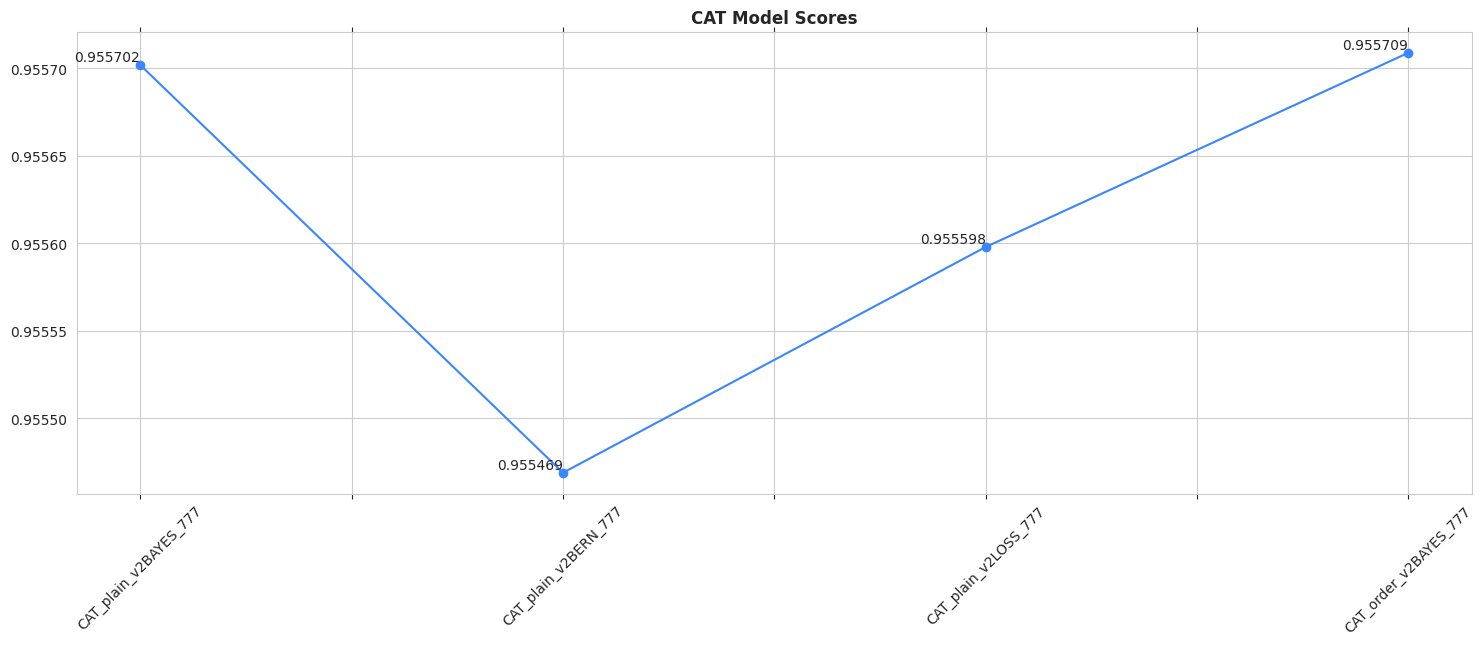

In [27]:
## -- Get Scores --
all_model_scores = {}

for k, v in all_model_predictions.items():
    for x, y in v.items():
        if x == 'score':
            # print(k, y)
            all_model_scores[k] = y

plt.figure(figsize=(18, 6))
pd.Series(all_model_scores).plot(marker='o')
plt.title('CAT Model Scores', fontweight='semibold')
for i, score in enumerate(all_model_scores.values()):
    plt.text(float(i), score+5e-6, score, ha='right', va='center_baseline')

plt.tick_params('x', rotation=45, reset=True)
plt.show()

In [28]:
## -- Get oof outputs --
all_model_oof = pd.DataFrame()

for i, (k, v) in enumerate(all_model_predictions.items()):
    for x, y in v.items():
        if x == 'oof_preds':
            n = f"{k}_{str(list(all_model_scores.values())[i]).split('.')[1]}"
            all_model_oof = pd.concat([all_model_oof, pd.DataFrame({n: y})], axis=1)

all_model_oof.to_parquet(f"oof_{version_name}_models.parquet", index=False)
all_model_oof.head()

,CAT_plain_v2BAYES_777_955702,CAT_plain_v2BERN_777_955469,CAT_plain_v2LOSS_777_955598,CAT_order_v2BAYES_777_955709
0,0.997419,0.996472,0.996869,0.997415
1,0.009441,0.012704,0.010338,0.009567
2,0.009167,0.012570,0.010613,0.009123
3,0.049806,0.039582,0.041037,0.049812
4,0.997471,0.991183,0.997357,0.997207


In [29]:
## -- Get test predictions --
all_model_test = pd.DataFrame()

for i, (k, v) in enumerate(all_model_predictions.items()):
    for x, y in v.items():
        if x == 'test_preds':
            n = f"{k}_{str(list(all_model_scores.values())[i]).split('.')[1]}"
            all_model_test = pd.concat([all_model_test, pd.DataFrame({n: y})], axis=1)

all_model_test.to_parquet(f"test_{version_name}_models.parquet", index=False)
all_model_test.head()

,CAT_plain_v2BAYES_777_955702,CAT_plain_v2BERN_777_955469,CAT_plain_v2LOSS_777_955598,CAT_order_v2BAYES_777_955709
0,0.942919,0.951514,0.957654,0.941972
1,0.007481,0.010826,0.008241,0.007428
2,0.990378,0.988107,0.988502,0.990492
3,0.003457,0.005486,0.004567,0.003497
4,0.198106,0.178258,0.183945,0.196435


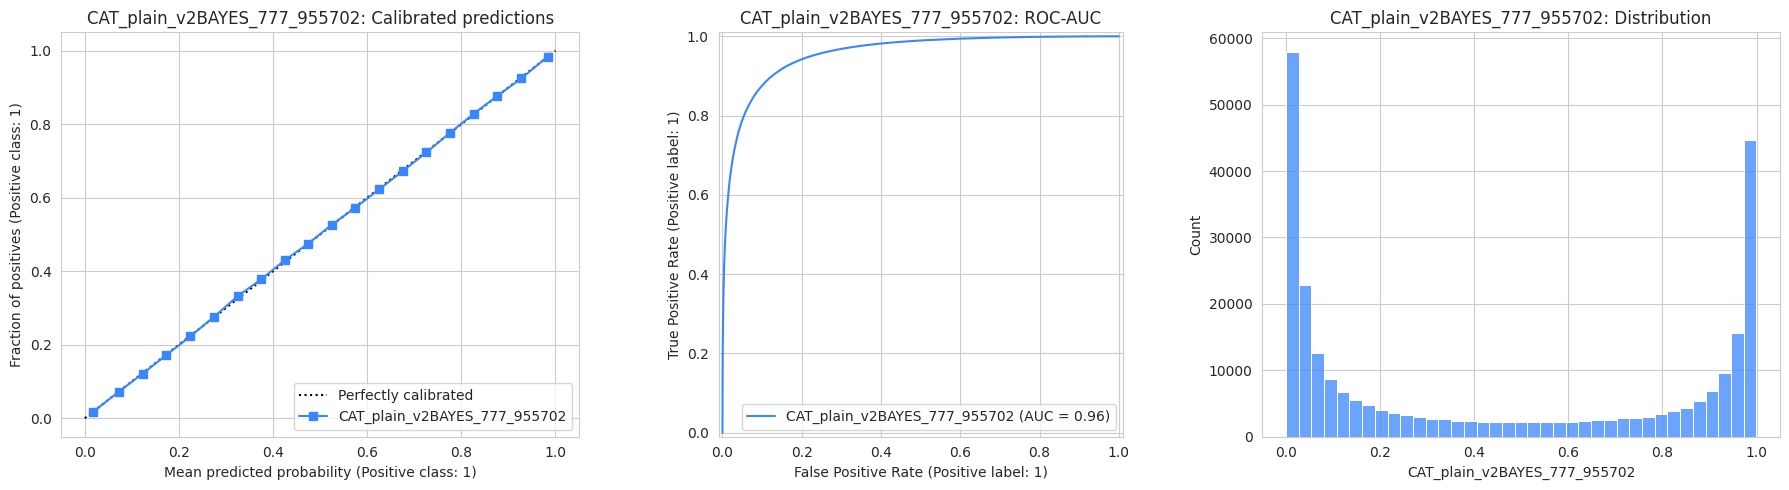

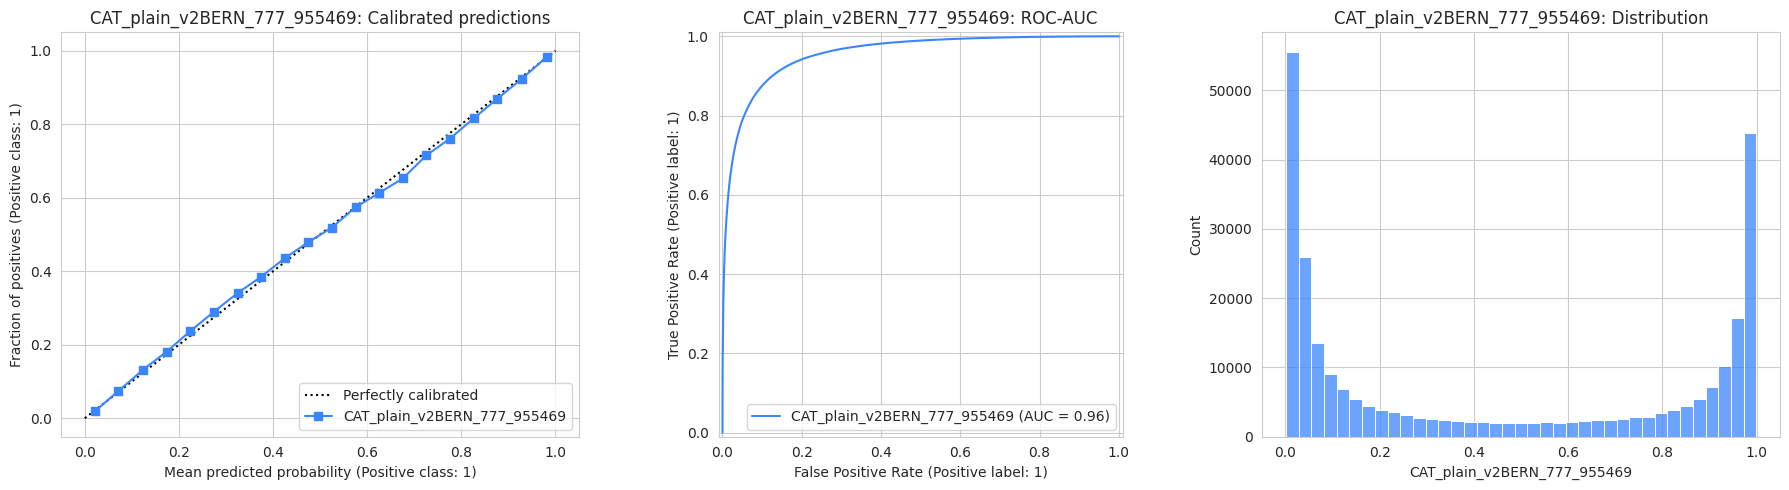

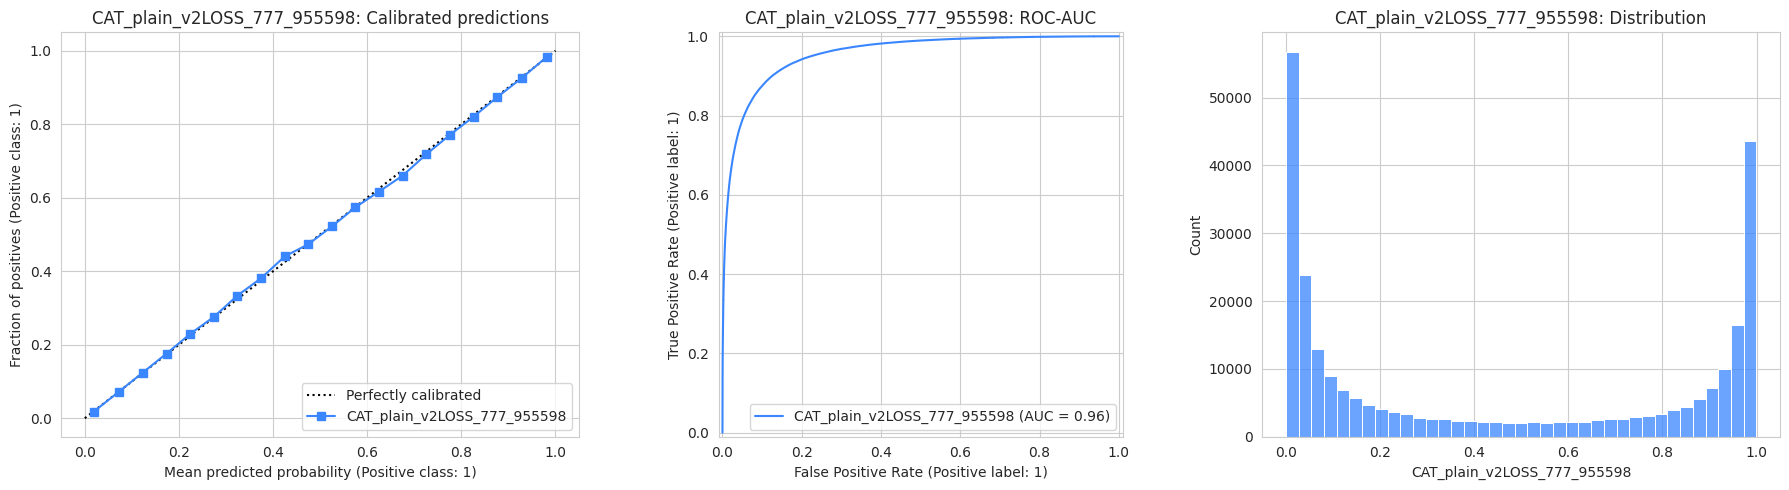

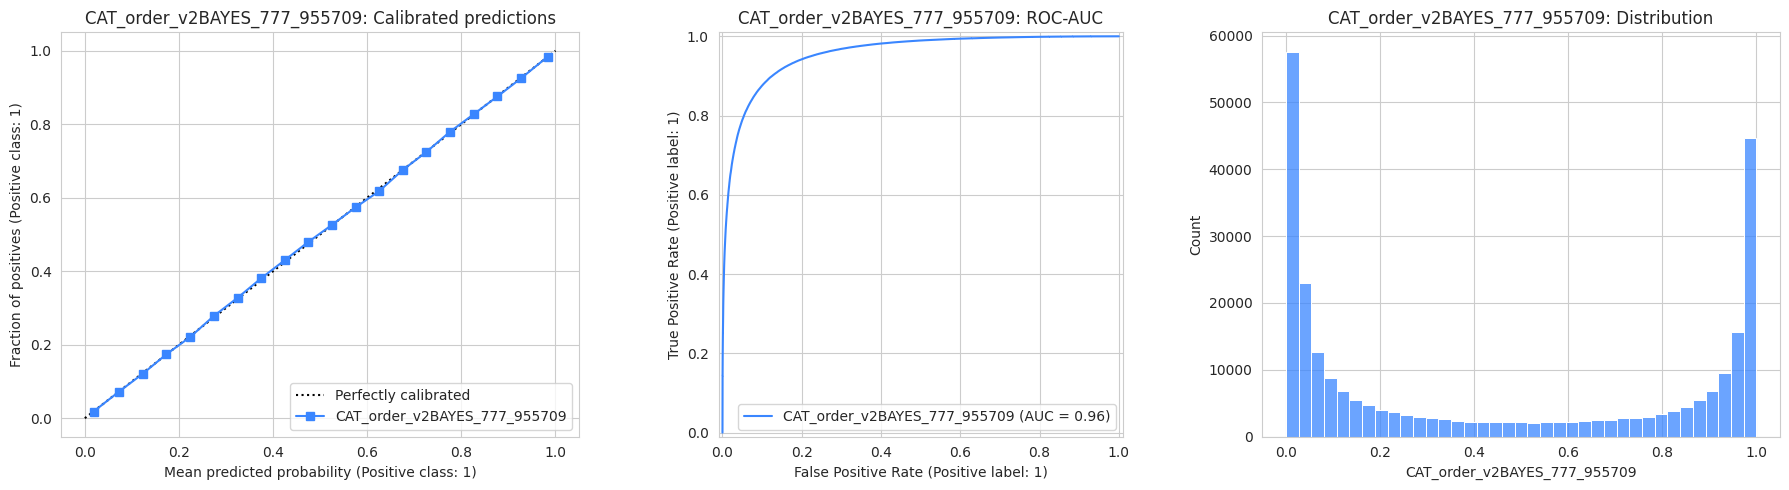

In [30]:
## -- Plot predictions --
for i, n in enumerate(all_model_test.columns):
    _, axs = plt.subplots(1, 3, figsize=(18, 5)) #, width_ratios=[0.6,0.4]

    # # Right: Confusion matrix (threshold = 0.5)
    # pred_labels = (all_model_oof[n] >= 0.5).astype('int8')
    # ConfusionMatrixDisplay.from_predictions(train[TARGET], pred_labels, cmap='Blues', colorbar=False, ax=axs[0])
    # axs[0].set_title(f"{n}: Confusion Matrix")
    # axs[0].grid(False)

    CalibrationDisplay.from_predictions(train[TARGET], all_model_oof[n], n_bins=20, name=n, ax=axs[0])
    axs[0].set_title(f"{n}: Calibrated predictions")

    # Left: ROC curve
    # score = [x for x in all_model_scores.values()][i]
    RocCurveDisplay.from_predictions(train[TARGET], all_model_oof[n], name=n, ax=axs[1])
    axs[1].set_title(f"{n}: ROC-AUC")
    # axs[1].grid(False)

    sns.histplot(all_model_test[n], ax=axs[2])
    axs[2].set_title(f"{n}: Distribution")

    plt.tight_layout()
    plt.show()
    print()

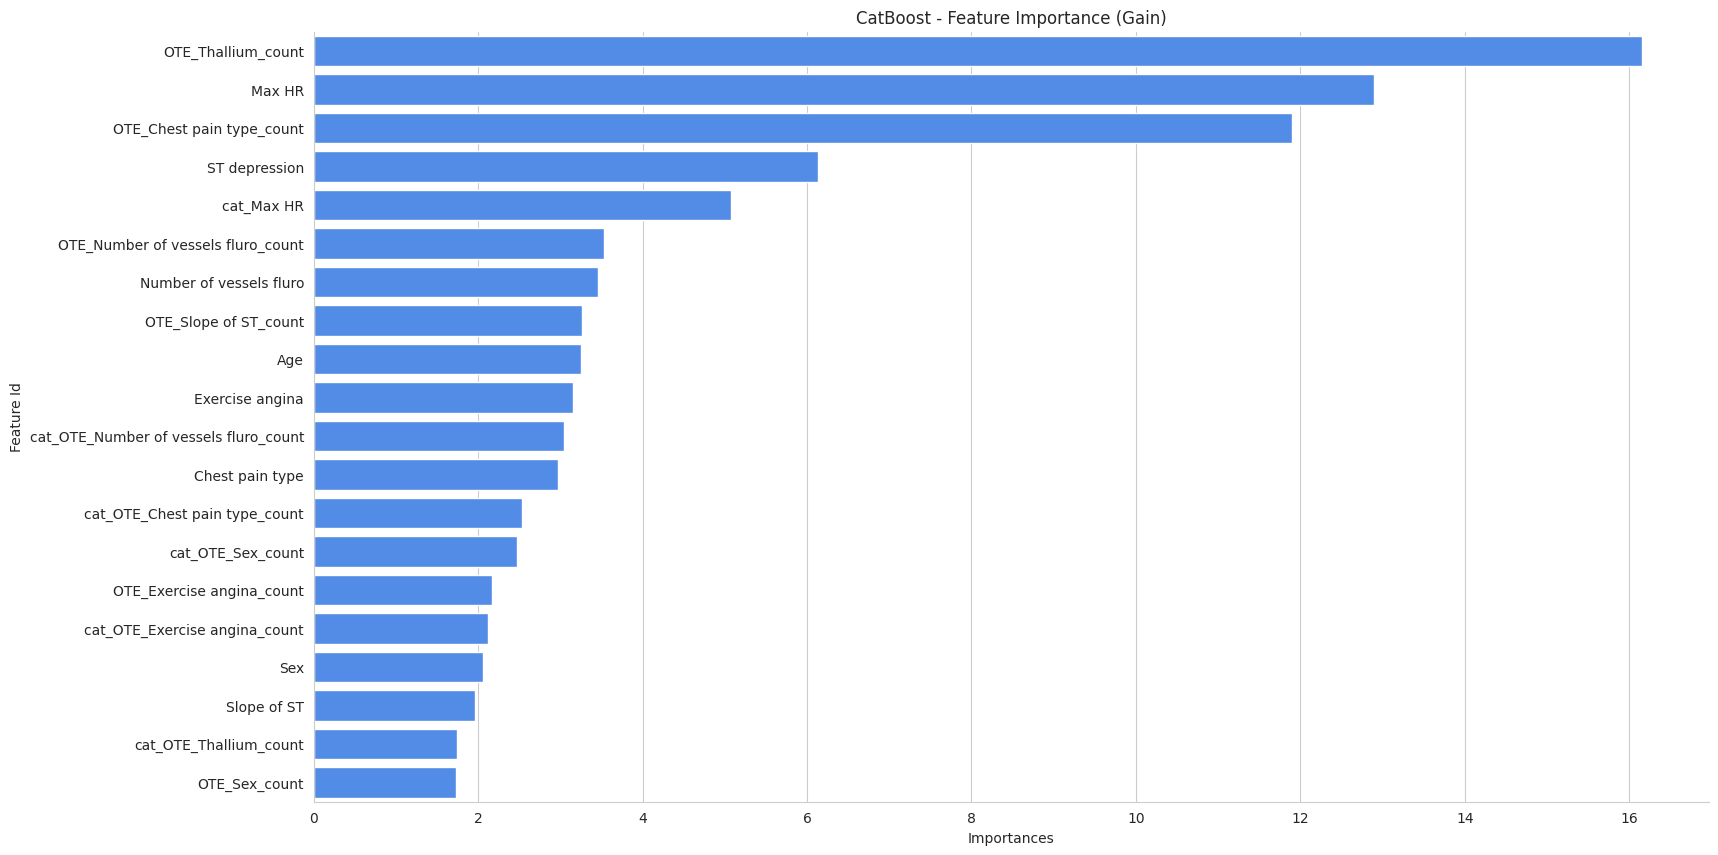

In [31]:
## -- Plot Feature Importances --
MAX = 20
get_model = all_model_predictions[list(all_model_predictions.keys())[-1]]
feature_importances = get_model['model'].get_feature_importance(prettified=True)

plt.figure(figsize=(18, 10))
ax = sns.barplot(x='Importances', y='Feature Id', data=feature_importances.head(MAX))
ax.set_title("CatBoost - Feature Importance (Gain)")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# plt.tight_layout()
plt.show()